In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import random
import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import math
import logging
from functools import partial
from collections import OrderedDict
from sklearn.metrics import classification_report
from torchsummary import summary

In [2]:
!nvidia-smi
torch.cuda.is_available()

Sat Sep 18 11:45:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   29C    P0     1W / 260W |      0MiB / 11011MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
###Read the EEG Spectrogram###

dat1 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C4_spec_30_np/spec_1_800_30.npy')
dat2 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C3_spec_30_np/spec_c3_1_800_30.npy')
print(dat1.shape)
print(dat2.shape)
dat_eeg = np.concatenate((dat1.reshape(-1,1,32,30), dat2.reshape(-1,1,32,30)), axis=1)
print(dat_eeg.shape)

(790121, 32, 30)
(790121, 32, 30)
(790121, 2, 32, 30)


In [4]:
###Read the EOG Spectrogram###

dat1 = np.load('/project/dsc-is/ziwei-y/EOG_seq_spec/Spec_EOG_L_1_800_30.npy')
dat2 = np.load('/project/dsc-is/ziwei-y/EOG_seq_spec/Spec_EOG_R_1_800_30.npy')
print(dat1.shape)
print(dat2.shape)
dat_eog = np.concatenate((dat1.reshape(-1,1,26,30), dat2.reshape(-1,1,26,30)), axis=1)
print(dat_eog.shape)

(790121, 26, 30)
(790121, 26, 30)
(790121, 2, 26, 30)


In [5]:
###Read the Lable###

index = pd.read_csv("/project/hikaku_db/data/sleep_SHHS/stages_sig/ann_delrecords_5class.csv", header=None)
print(index[0 : 790121].apply(pd.value_counts))
label = index[0 : 790121].values.tolist()#list
print(len(label))

        0
2  329696
0  221935
4  109008
3  100831
1   28651
790121


In [6]:
fixdata = dat_eeg[:,:,0:16,:]
mean_p1 = np.mean(dat_eeg[:,:,16:20,:], axis = 2)
mean_p2 = np.mean(dat_eeg[:,:,20:24,:], axis = 2)
mean_p3 = np.mean(dat_eeg[:,:,24:28,:], axis = 2)
mean_p4 = np.mean(dat_eeg[:,:,28:32,:], axis = 2)
num_data = len(dat_eeg)
ch = 2
inputeeg = np.concatenate((fixdata,mean_p1.reshape(num_data, ch, 1, 30),mean_p2.reshape(num_data, ch, 1, 30),mean_p3.reshape(num_data, ch, 1, 30),mean_p4.reshape(num_data, ch, 1, 30)),axis=2)
print(inputeeg.shape)

(790121, 2, 20, 30)


In [7]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1, data2, label ,transform = None):
        self.transform = transform

        self.data1 = data1
        self.data2 = data2
        self.label = label

        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float()
        out_data2 = torch.tensor(self.data2[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data1 = self.transform(out_data1)
            out_data2 = self.transform(out_data2)

        return out_data1, out_data2, out_label

In [8]:
train_eeg, test_eeg, train_label, test_label = train_test_split(inputeeg, np.array(label), test_size = 0.1, stratify = label,random_state = 66)
print('train eeg data:',len(train_eeg))
print('test eeg data:',len(test_eeg))

train_eog, test_eog, train_label, test_label = train_test_split(dat_eog, np.array(label), test_size = 0.1, stratify = label,random_state = 66)
print('train eog data:',len(train_eeg))
print('test eog data:',len(test_eeg))

train_data_set = Mydatasets(data1 = train_eeg, data2 = train_eog, label = train_label)
test_data_set = Mydatasets(data1 = test_eeg, data2 = test_eog, label = test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train eeg data: 711108
test eeg data: 79013
train eog data: 711108
test eog data: 79013


In [9]:
##Transformer model

class PreNorm(nn.Module): 
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 8, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads       ##32(4*8)   
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)   

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):           ##Register the blocks into whole network
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, time_size, fre_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels , dim_head, dropout = 0, emb_dropout = 0.):
        super().__init__()
        assert image_size == 30  ##Time dimensions must equal to 30s
        num_patches = 180       #30*5+30*1(5EEG+1EOG)
        patch_dim = channels * time_size * fre_size    #EEG_patch_dim:2*1*4  
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.eog_to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = 26, p2 = 1),
            nn.Linear(26*2, dim),             ##eog_patch_dim(26*2) to embed_dim
        )
        
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p3) (w p4) -> b (h w) (p3 p4 c)', p3 = fre_size, p4 = time_size),
            nn.Linear(patch_dim, dim),       ##eeg_patch_dim(2*1*4) to embed_dim
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) ##Generate the pos value'
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))                ##Generate the class value'
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)      

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, eeg, eog):
        EEG = self.to_patch_embedding(eeg)
        EOG = self.eog_to_patch_embedding(eog)
        x = torch.cat((EEG, EOG), dim=1)            
        
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '(      ) n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [16]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Transmodel = ViT(
    image_size = 30, 
    time_size = 1, 
    fre_size = 4, 
    num_classes = 5, 
    dim = 128,   
    depth = 8,   
    heads = 4, 
    mlp_dim = 512, 
    channels = 2,
    dim_head = 8
).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-4)

#Transmodel.load_state_dict(torch.load('/project/hikaku_db/ziwei/Model_2/state_1/Model_2_state_1'))

cuda:0


In [17]:
EPOCH = 100
loss_list=[]
los_min=10**10
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    for _, (inputs1, inputs2, labels) in enumerate(train_dataloader, 0):

        optimizer.zero_grad()
        inputs1 = inputs1.to(DEVICE)
        inputs2 = inputs2.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = Transmodel(inputs1,inputs2)
        
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        count=count+1

        # print statistics
        running_loss += loss.item()
    loss_loss=running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)
    with torch.no_grad():
        count=0
        running_loss=0.0
        pre=list()
        lab=list()
        for _, (inputs1, inputs2, labels) in enumerate(test_dataloader, 0):
            inputs1=inputs1.to(DEVICE)
            inputs2=inputs2.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = Transmodel(inputs1,inputs2)
            loss =criterion(outputs, labels.squeeze())
            running_loss += loss.item()
            count+=1
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            predicted=predicted.to('cpu')
            labels=labels.to('cpu')
            predicted=predicted.tolist()
            labels=labels.tolist()
            pre.append(predicted)
            lab.append(labels)
        loss_loss=running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])
#         if los_min>loss_loss:
#             los_min=loss_loss
#             torch.save(Transmodel.state_dict(),'Trans_8lay_state') 

        torch.save(Transmodel.state_dict(),'/project/hikaku_db/ziwei/Model_2/Hyper_test/Model_2_state_1')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1 :finished
train_loss: 0.49374063790938766


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


val_loss: 0.44358181237933125
{'0': {'precision': 0.9358517462580185, 'recall': 0.8874020005406866, 'f1-score': 0.9109831402206341, 'support': 22194}, '1': {'precision': 0.4336569579288026, 'recall': 0.09354275741710297, 'f1-score': 0.15389032443296008, 'support': 2865}, '2': {'precision': 0.802735162148365, 'recall': 0.9061874431301183, 'f1-score': 0.851329980481272, 'support': 32970}, '3': {'precision': 0.8461863065724232, 'recall': 0.7954973718139443, 'f1-score': 0.8200592986402209, 'support': 10083}, '4': {'precision': 0.7780698460383026, 'recall': 0.7602972204384919, 'f1-score': 0.7690808704124716, 'support': 10901}, 'accuracy': 0.8371913482591472, 'macro avg': {'precision': 0.7593000037891825, 'recall': 0.6885853586680688, 'f1-score': 0.7010687228375116, 'support': 79013}, 'weighted avg': {'precision': 0.8288855638664696, 'recall': 0.8371913482591472, 'f1-score': 0.8274589438014051, 'support': 79013}}


  1%|          | 1/100 [07:22<12:09:31, 442.13s/it]

epoch 2 :finished
train_loss: 0.4229205529184716
val_loss: 0.4205873001683579
{'0': {'precision': 0.892458399281345, 'recall': 0.9400288366225106, 'f1-score': 0.9156261657633143, 'support': 22194}, '1': {'precision': 0.41962174940898345, 'recall': 0.12390924956369982, 'f1-score': 0.19132309350579355, 'support': 2865}, '2': {'precision': 0.8306211127204567, 'recall': 0.8870791628753412, 'f1-score': 0.8579222950675408, 'support': 32970}, '3': {'precision': 0.8253937007874016, 'recall': 0.8316969156005157, 'f1-score': 0.8285333201600553, 'support': 10083}, '4': {'precision': 0.8446756555897653, 'recall': 0.7298412989633979, 'f1-score': 0.7830708661417323, 'support': 10901}, 'accuracy': 0.845519091795021, 'macro avg': {'precision': 0.7625541235575903, 'recall': 0.702511092725093, 'f1-score': 0.7152951481276872, 'support': 79013}, 'weighted avg': {'precision': 0.8343597903980835, 'recall': 0.845519091795021, 'f1-score': 0.8358827387038432, 'support': 79013}}


  2%|▏         | 2/100 [14:45<12:02:32, 442.38s/it]

epoch 3 :finished
train_loss: 0.40000644615194925
val_loss: 0.39801579056239805
{'0': {'precision': 0.9221296793838438, 'recall': 0.9278633865008561, 'f1-score': 0.924987647666532, 'support': 22194}, '1': {'precision': 0.45, 'recall': 0.14764397905759163, 'f1-score': 0.22233902759526944, 'support': 2865}, '2': {'precision': 0.838307819493144, 'recall': 0.891932059447983, 'f1-score': 0.8642889682434717, 'support': 32970}, '3': {'precision': 0.8242400997219292, 'recall': 0.8525240503818308, 'f1-score': 0.8381435257410296, 'support': 10083}, '4': {'precision': 0.8219485976741914, 'recall': 0.7715805889367948, 'f1-score': 0.7959685814327624, 'support': 10901}, 'accuracy': 0.8534038702491995, 'macro avg': {'precision': 0.7713252392546217, 'recall': 0.7183088128650112, 'f1-score': 0.729145550135813, 'support': 79013}, 'weighted avg': {'precision': 0.8437203941335801, 'recall': 0.8534038702491995, 'f1-score': 0.8452993700480183, 'support': 79013}}


  3%|▎         | 3/100 [22:08<11:55:31, 442.59s/it]

epoch 4 :finished
train_loss: 0.3831989878877096
val_loss: 0.3966463381824223
{'0': {'precision': 0.9249943958753643, 'recall': 0.9296206181850951, 'f1-score': 0.927301737117688, 'support': 22194}, '1': {'precision': 0.3476548514142499, 'recall': 0.3389179755671902, 'f1-score': 0.34323082361258395, 'support': 2865}, '2': {'precision': 0.8532083296825258, 'recall': 0.8860479223536548, 'f1-score': 0.8693180972786383, 'support': 32970}, '3': {'precision': 0.8486983154670751, 'recall': 0.8244570068432014, 'f1-score': 0.8364020525203743, 'support': 10083}, '4': {'precision': 0.8407043821475559, 'recall': 0.7620401798000184, 'f1-score': 0.7994418246559524, 'support': 10901}, 'accuracy': 0.8534798071203473, 'macro avg': {'precision': 0.7630520549173541, 'recall': 0.748216740549832, 'f1-score': 0.7551389070370474, 'support': 79013}, 'weighted avg': {'precision': 0.8527404222803534, 'recall': 0.8534798071203473, 'f1-score': 0.8526883671883639, 'support': 79013}}


  4%|▍         | 4/100 [29:31<11:48:22, 442.74s/it]

epoch 5 :finished
train_loss: 0.3692755642976636
val_loss: 0.3749636257105028
{'0': {'precision': 0.9407900780891134, 'recall': 0.9228169775615032, 'f1-score': 0.9317168592484761, 'support': 22194}, '1': {'precision': 0.42837370242214534, 'recall': 0.21605584642233858, 'f1-score': 0.2872389791183295, 'support': 2865}, '2': {'precision': 0.864399187768753, 'recall': 0.8779799818016378, 'f1-score': 0.8711366577387223, 'support': 32970}, '3': {'precision': 0.8351037910535035, 'recall': 0.8498462759099474, 'f1-score': 0.842410538733779, 'support': 10083}, '4': {'precision': 0.7790688023902399, 'recall': 0.8611136592973122, 'f1-score': 0.8180392156862746, 'support': 10901}, 'accuracy': 0.860655841443813, 'macro avg': {'precision': 0.7695471123447511, 'recall': 0.7455625481985478, 'f1-score': 0.7501084501051162, 'support': 79013}, 'weighted avg': {'precision': 0.8545354234282143, 'recall': 0.860655841443813, 'f1-score': 0.8559896498959557, 'support': 79013}}


  5%|▌         | 5/100 [36:54<11:41:06, 442.80s/it]

epoch 6 :finished
train_loss: 0.3571637547544765
val_loss: 0.3661198368801279
{'0': {'precision': 0.9498277948431537, 'recall': 0.9195278003063891, 'f1-score': 0.9344322344322344, 'support': 22194}, '1': {'precision': 0.43219264892268694, 'recall': 0.23804537521815008, 'f1-score': 0.3069997749268512, 'support': 2865}, '2': {'precision': 0.8491599395270559, 'recall': 0.902911737943585, 'f1-score': 0.8752113131550708, 'support': 32970}, '3': {'precision': 0.8533062054933875, 'recall': 0.8318952692650997, 'f1-score': 0.8424647215386932, 'support': 10083}, '4': {'precision': 0.8171216778159465, 'recall': 0.8291899825704064, 'f1-score': 0.8231115967763967, 'support': 10901}, 'accuracy': 0.8642375305329503, 'macro avg': {'precision': 0.7803216533204461, 'recall': 0.7443140330607261, 'f1-score': 0.7564439281658493, 'support': 79013}, 'weighted avg': {'precision': 0.8584263741913476, 'recall': 0.8642375305329503, 'f1-score': 0.8598758642832354, 'support': 79013}}


  6%|▌         | 6/100 [44:17<11:33:46, 442.83s/it]

epoch 7 :finished
train_loss: 0.3457106292332255
val_loss: 0.36236931573041536
{'0': {'precision': 0.9156048175946937, 'recall': 0.9453906461205731, 'f1-score': 0.9302593659942363, 'support': 22194}, '1': {'precision': 0.4858757062146893, 'recall': 0.15008726003490402, 'f1-score': 0.22933333333333333, 'support': 2865}, '2': {'precision': 0.8609176566980745, 'recall': 0.8923566878980892, 'f1-score': 0.8763552960800667, 'support': 32970}, '3': {'precision': 0.8417357386640663, 'recall': 0.8560944163443419, 'f1-score': 0.8488543612941292, 'support': 10083}, '4': {'precision': 0.8331633126217194, 'recall': 0.8241445738923034, 'f1-score': 0.8286294041689725, 'support': 10901}, 'accuracy': 0.8663004821991318, 'macro avg': {'precision': 0.7874594463586486, 'recall': 0.7336147168580422, 'f1-score': 0.7426863521741476, 'support': 79013}, 'weighted avg': {'precision': 0.8564028335232985, 'recall': 0.8663004821991318, 'f1-score': 0.8579415810108534, 'support': 79013}}


  7%|▋         | 7/100 [51:40<11:26:37, 442.98s/it]

epoch 8 :finished
train_loss: 0.3343130320168447
val_loss: 0.35886555229604
{'0': {'precision': 0.9612583884631859, 'recall': 0.9100207263224295, 'f1-score': 0.934938085869691, 'support': 22194}, '1': {'precision': 0.44816053511705684, 'recall': 0.2338568935427574, 'f1-score': 0.3073394495412844, 'support': 2865}, '2': {'precision': 0.8621656348557412, 'recall': 0.8954807400667273, 'f1-score': 0.878507453804267, 'support': 32970}, '3': {'precision': 0.8490435127366439, 'recall': 0.8495487454130715, 'f1-score': 0.849296053936149, 'support': 10083}, '4': {'precision': 0.785033678330869, 'recall': 0.8767085588478122, 'f1-score': 0.8283423618634886, 'support': 10901}, 'accuracy': 0.8671231316365662, 'macro avg': {'precision': 0.7811323499006994, 'recall': 0.7531231328385596, 'f1-score': 0.759684681002976, 'support': 79013}, 'weighted avg': {'precision': 0.8626720597150405, 'recall': 0.8671231316365662, 'f1-score': 0.8629990805458148, 'support': 79013}}


  8%|▊         | 8/100 [59:03<11:19:15, 443.00s/it]

epoch 9 :finished
train_loss: 0.32408370194209724
val_loss: 0.35256993366397826
{'0': {'precision': 0.9216901903882513, 'recall': 0.9444895016671172, 'f1-score': 0.9329505752497941, 'support': 22194}, '1': {'precision': 0.49842602308499473, 'recall': 0.16579406631762653, 'f1-score': 0.24882137244630698, 'support': 2865}, '2': {'precision': 0.8675120630810874, 'recall': 0.894297846527146, 'f1-score': 0.8807013351653276, 'support': 32970}, '3': {'precision': 0.8822329575952764, 'recall': 0.8150352077754637, 'f1-score': 0.8473038457572947, 'support': 10083}, '4': {'precision': 0.792825037456301, 'recall': 0.8737730483441886, 'f1-score': 0.8313331878682086, 'support': 10901}, 'accuracy': 0.8690342095604521, 'macro avg': {'precision': 0.7925372543211822, 'recall': 0.7386779341263083, 'f1-score': 0.7482220632973864, 'support': 79013}, 'weighted avg': {'precision': 0.8609215699459978, 'recall': 0.8690342095604521, 'f1-score': 0.861392797100168, 'support': 79013}}


  9%|▉         | 9/100 [1:06:27<11:12:07, 443.16s/it]

epoch 10 :finished
train_loss: 0.3135277077346461
val_loss: 0.34584543029909676
{'0': {'precision': 0.9278792973762223, 'recall': 0.9448950166711724, 'f1-score': 0.9363098560107155, 'support': 22194}, '1': {'precision': 0.4441846873173583, 'recall': 0.26527050610820246, 'f1-score': 0.3321678321678322, 'support': 2865}, '2': {'precision': 0.8670450888024109, 'recall': 0.8987867758568395, 'f1-score': 0.8826306461941711, 'support': 32970}, '3': {'precision': 0.8774452786295865, 'recall': 0.8229693543588218, 'f1-score': 0.8493346980552713, 'support': 10083}, '4': {'precision': 0.829312370109334, 'recall': 0.8419411063205211, 'f1-score': 0.83557902403496, 'support': 10901}, 'accuracy': 0.8712490349689291, 'macro avg': {'precision': 0.7891733444469825, 'recall': 0.7547725518631114, 'f1-score': 0.76720441129259, 'support': 79013}, 'weighted avg': {'precision': 0.8649213891882549, 'recall': 0.8712490349689291, 'f1-score': 0.8670085035371506, 'support': 79013}}


 10%|█         | 10/100 [1:13:50<11:04:42, 443.14s/it]

epoch 11 :finished
train_loss: 0.3033688364093191
val_loss: 0.3455403030702942
{'0': {'precision': 0.9442181851462041, 'recall': 0.9297107326304407, 'f1-score': 0.9369083024950622, 'support': 22194}, '1': {'precision': 0.4720110573600553, 'recall': 0.23839441535776615, 'f1-score': 0.3167903525046382, 'support': 2865}, '2': {'precision': 0.8544978066427391, 'recall': 0.9098574461631787, 'f1-score': 0.8813091250954816, 'support': 32970}, '3': {'precision': 0.8677600166078472, 'recall': 0.8291183179609243, 'f1-score': 0.847999188517523, 'support': 10083}, '4': {'precision': 0.8365989246331905, 'recall': 0.8421245757269975, 'f1-score': 0.8393526561214225, 'support': 10901}, 'accuracy': 0.8714388771467986, 'macro avg': {'precision': 0.7950171980780072, 'recall': 0.7498410975678615, 'f1-score': 0.7644719249468255, 'support': 79013}, 'weighted avg': {'precision': 0.8650534961381781, 'recall': 0.8714388771467986, 'f1-score': 0.8664177819105848, 'support': 79013}}


 11%|█         | 11/100 [1:21:13<10:57:18, 443.13s/it]

epoch 12 :finished
train_loss: 0.29272875180528307
val_loss: 0.34677806548502765
{'0': {'precision': 0.9396586845321624, 'recall': 0.9352978282418671, 'f1-score': 0.9374731850513718, 'support': 22194}, '1': {'precision': 0.4878228782287823, 'recall': 0.23071553228621292, 'f1-score': 0.31327014218009475, 'support': 2865}, '2': {'precision': 0.8649705315982961, 'recall': 0.8991810737033668, 'f1-score': 0.8817440961275356, 'support': 32970}, '3': {'precision': 0.8779418057338468, 'recall': 0.8139442626202519, 'f1-score': 0.8447326437136534, 'support': 10083}, '4': {'precision': 0.7996651318543324, 'recall': 0.876249885331621, 'f1-score': 0.8362076512299746, 'support': 10901}, 'accuracy': 0.8710465366458684, 'macro avg': {'precision': 0.7940118063894841, 'recall': 0.751077716436664, 'f1-score': 0.7626855436605261, 'support': 79013}, 'weighted avg': {'precision': 0.8649198568208591, 'recall': 0.8710465366458684, 'f1-score': 0.8657795619495994, 'support': 79013}}


 12%|█▏        | 12/100 [1:28:36<10:49:52, 443.10s/it]

epoch 13 :finished
train_loss: 0.281631281926941
val_loss: 0.3493683475473149
{'0': {'precision': 0.941571402649247, 'recall': 0.9352077137965216, 'f1-score': 0.9383787693837877, 'support': 22194}, '1': {'precision': 0.48510919920582396, 'recall': 0.2558464223385689, 'f1-score': 0.33500914076782445, 'support': 2865}, '2': {'precision': 0.8707076739325171, 'recall': 0.8844404003639672, 'f1-score': 0.8775203129702076, 'support': 32970}, '3': {'precision': 0.8203526818515797, 'recall': 0.885847466031935, 'f1-score': 0.8518430213151496, 'support': 10083}, '4': {'precision': 0.8278880866425993, 'recall': 0.8414824328043299, 'f1-score': 0.8346299076475138, 'support': 10901}, 'accuracy': 0.8701606064824776, 'macro avg': {'precision': 0.7891258088563534, 'recall': 0.7605648870670645, 'f1-score': 0.7674762304168966, 'support': 79013}, 'weighted avg': {'precision': 0.8642973902937189, 'recall': 0.8701606064824776, 'f1-score': 0.8657494098669528, 'support': 79013}}


 13%|█▎        | 13/100 [1:35:59<10:42:28, 443.09s/it]

epoch 14 :finished
train_loss: 0.2706571577155065
val_loss: 0.3520683722457422
{'0': {'precision': 0.9312162222519987, 'recall': 0.9393980355050915, 'f1-score': 0.9352892358073707, 'support': 22194}, '1': {'precision': 0.44216867469879517, 'recall': 0.256195462478185, 'f1-score': 0.3244198895027624, 'support': 2865}, '2': {'precision': 0.870386291541905, 'recall': 0.8904761904761904, 'f1-score': 0.8803166369319799, 'support': 32970}, '3': {'precision': 0.8654928856587163, 'recall': 0.8385401170286622, 'f1-score': 0.8518033447511586, 'support': 10083}, '4': {'precision': 0.8167306350314026, 'recall': 0.8589120264195945, 'f1-score': 0.837290409121395, 'support': 10901}, 'accuracy': 0.8702365433536253, 'macro avg': {'precision': 0.7851989418365636, 'recall': 0.7567043663815447, 'f1-score': 0.7658239032229333, 'support': 79013}, 'weighted avg': {'precision': 0.8639186911063202, 'recall': 0.8702365433536253, 'f1-score': 0.8660264472623471, 'support': 79013}}


 14%|█▍        | 14/100 [1:43:22<10:35:02, 443.05s/it]

epoch 15 :finished
train_loss: 0.2589476667495432
val_loss: 0.35142808204841036
{'0': {'precision': 0.9504844916315082, 'recall': 0.923718122014959, 'f1-score': 0.9369101752622078, 'support': 22194}, '1': {'precision': 0.4647535870243294, 'recall': 0.2600349040139616, 'f1-score': 0.3334825425246195, 'support': 2865}, '2': {'precision': 0.8595293643250094, 'recall': 0.905125872004853, 'f1-score': 0.8817385394968165, 'support': 32970}, '3': {'precision': 0.863493670886076, 'recall': 0.8456808489536844, 'f1-score': 0.854494438320473, 'support': 10083}, '4': {'precision': 0.8225304525651285, 'recall': 0.8486377396569122, 'f1-score': 0.8353801697670218, 'support': 10901}, 'accuracy': 0.8715780947439029, 'macro avg': {'precision': 0.7921583132864103, 'recall': 0.7566394973288741, 'f1-score': 0.7684011730742277, 'support': 79013}, 'weighted avg': {'precision': 0.8661646326914143, 'recall': 0.8715780947439029, 'f1-score': 0.8674835560417671, 'support': 79013}}


 15%|█▌        | 15/100 [1:50:45<10:27:36, 443.02s/it]

epoch 16 :finished
train_loss: 0.24763050049682844
val_loss: 0.3691395724229967
{'0': {'precision': 0.9398202777525643, 'recall': 0.9330449671082275, 'f1-score': 0.9364203671882066, 'support': 22194}, '1': {'precision': 0.4259359739555073, 'recall': 0.27399650959860383, 'f1-score': 0.3334749362786746, 'support': 2865}, '2': {'precision': 0.8517329545454545, 'recall': 0.9093418259023355, 'f1-score': 0.8795951298225025, 'support': 32970}, '3': {'precision': 0.8706697459584296, 'recall': 0.8225726470296538, 'f1-score': 0.8459380896527104, 'support': 10083}, '4': {'precision': 0.8517771373679155, 'recall': 0.81341161361343, 'f1-score': 0.8321524095537516, 'support': 10901}, 'accuracy': 0.8686545252047132, 'macro avg': {'precision': 0.7879872179159741, 'recall': 0.7504735126504501, 'f1-score': 0.7655161864991691, 'support': 79013}, 'weighted avg': {'precision': 0.8634591642404803, 'recall': 0.8686545252047132, 'f1-score': 0.8649141018133104, 'support': 79013}}


 16%|█▌        | 16/100 [1:58:09<10:20:39, 443.32s/it]

epoch 17 :finished
train_loss: 0.23474403347014106
val_loss: 0.3685119610023402
{'0': {'precision': 0.9223527341515991, 'recall': 0.9446697305578085, 'f1-score': 0.9333778519755148, 'support': 22194}, '1': {'precision': 0.4533807829181495, 'recall': 0.22233856893542758, 'f1-score': 0.29836065573770487, 'support': 2865}, '2': {'precision': 0.8724339740352337, 'recall': 0.8907188353048225, 'f1-score': 0.8814815926520689, 'support': 32970}, '3': {'precision': 0.8643037974683544, 'recall': 0.8464742636120203, 'f1-score': 0.8552961218558974, 'support': 10083}, '4': {'precision': 0.8237368838726744, 'recall': 0.8569855976515915, 'f1-score': 0.8400323711896412, 'support': 10901}, 'accuracy': 0.8713376279852683, 'macro avg': {'precision': 0.7872416344892023, 'recall': 0.7522373992123341, 'f1-score': 0.7617097186821654, 'support': 79013}, 'weighted avg': {'precision': 0.8635048866608304, 'recall': 0.8713376279852683, 'f1-score': 0.8658547721284233, 'support': 79013}}


 17%|█▋        | 17/100 [2:05:32<10:13:03, 443.18s/it]

epoch 18 :finished
train_loss: 0.2222504023642898
val_loss: 0.38549509655970793
{'0': {'precision': 0.9493647321636338, 'recall': 0.919122285302334, 'f1-score': 0.9339987637645658, 'support': 22194}, '1': {'precision': 0.42689295039164493, 'recall': 0.22827225130890053, 'f1-score': 0.2974755515123948, 'support': 2865}, '2': {'precision': 0.8485627879370283, 'recall': 0.910615711252654, 'f1-score': 0.8784948281663765, 'support': 32970}, '3': {'precision': 0.8812399786210583, 'recall': 0.817613805415055, 'f1-score': 0.8482354151661694, 'support': 10083}, '4': {'precision': 0.8206608633860366, 'recall': 0.8475369232180534, 'f1-score': 0.8338823954149556, 'support': 10901}, 'accuracy': 0.8676926581701745, 'macro avg': {'precision': 0.7853442624998804, 'recall': 0.7446321952993993, 'f1-score': 0.7584173908048923, 'support': 79013}, 'weighted avg': {'precision': 0.8619079273411071, 'recall': 0.8676926581701745, 'f1-score': 0.8630012806279743, 'support': 79013}}


 18%|█▊        | 18/100 [2:12:54<10:05:31, 443.06s/it]

epoch 19 :finished
train_loss: 0.21002202328191258
val_loss: 0.3957108119781683
{'0': {'precision': 0.933018018018018, 'recall': 0.9332702532215914, 'f1-score': 0.9331441185745821, 'support': 22194}, '1': {'precision': 0.4055036344755971, 'recall': 0.27260034904013963, 'f1-score': 0.3260279691087456, 'support': 2865}, '2': {'precision': 0.8658507745063261, 'recall': 0.8883833788292387, 'f1-score': 0.8769723644420491, 'support': 32970}, '3': {'precision': 0.8541458541458542, 'recall': 0.8479619160963999, 'f1-score': 0.8510426516697357, 'support': 10083}, '4': {'precision': 0.8299393610281474, 'recall': 0.8412072286946152, 'f1-score': 0.8355353075170843, 'support': 10901}, 'accuracy': 0.8669965701846531, 'macro avg': {'precision': 0.7776915284347886, 'recall': 0.756684625176397, 'f1-score': 0.7645444822624394, 'support': 79013}, 'weighted avg': {'precision': 0.8615771007563126, 'recall': 0.8669965701846531, 'f1-score': 0.8637475225447062, 'support': 79013}}


 19%|█▉        | 19/100 [2:20:17<9:58:03, 443.00s/it] 

epoch 20 :finished
train_loss: 0.19796960984770398
val_loss: 0.40819662187987493
{'0': {'precision': 0.9273675762439807, 'recall': 0.9371451743714517, 'f1-score': 0.9322307382008874, 'support': 22194}, '1': {'precision': 0.40318799812470696, 'recall': 0.30017452006980805, 'f1-score': 0.3441376550620248, 'support': 2865}, '2': {'precision': 0.8688069284754367, 'recall': 0.8823779193205945, 'f1-score': 0.8755398389887894, 'support': 32970}, '3': {'precision': 0.8726910159529807, 'recall': 0.8246553605077854, 'f1-score': 0.8479934730508389, 'support': 10083}, '4': {'precision': 0.8087245388582918, 'recall': 0.8486377396569122, 'f1-score': 0.8282005371530886, 'support': 10901}, 'accuracy': 0.8646298710338804, 'macro avg': {'precision': 0.7761556115310795, 'recall': 0.7585981427853103, 'f1-score': 0.7656204484911258, 'support': 79013}, 'weighted avg': {'precision': 0.860579192608425, 'recall': 0.8646298710338804, 'f1-score': 0.8621488124880844, 'support': 79013}}


 20%|██        | 20/100 [2:27:40<9:50:41, 443.02s/it]

epoch 21 :finished
train_loss: 0.18583364667682026
val_loss: 0.41542346647031875
{'0': {'precision': 0.9379417263234691, 'recall': 0.9268270703793818, 'f1-score': 0.9323512747875353, 'support': 22194}, '1': {'precision': 0.4032757857459053, 'recall': 0.31797556719022685, 'f1-score': 0.35558157689305225, 'support': 2865}, '2': {'precision': 0.8676051265119908, 'recall': 0.8767364270548984, 'f1-score': 0.872146876461448, 'support': 32970}, '3': {'precision': 0.8392107062616001, 'recall': 0.8520281662203709, 'f1-score': 0.8455708661417324, 'support': 10083}, '4': {'precision': 0.8153341024048274, 'recall': 0.8428584533529034, 'f1-score': 0.8288678394226433, 'support': 10901}, 'accuracy': 0.8627187931099946, 'macro avg': {'precision': 0.7726734894495585, 'recall': 0.7632851368395562, 'f1-score': 0.7669036867412822, 'support': 79013}, 'weighted avg': {'precision': 0.8596904740085323, 'recall': 0.8627187931099946, 'f1-score': 0.8609647436272564, 'support': 79013}}


 21%|██        | 21/100 [2:35:03<9:43:17, 443.01s/it]

epoch 22 :finished
train_loss: 0.17452742312575542
val_loss: 0.43383129600450576
{'0': {'precision': 0.9258632965468138, 'recall': 0.9374605749301613, 'f1-score': 0.9316258451618681, 'support': 22194}, '1': {'precision': 0.41341396371632766, 'recall': 0.262478184991274, 'f1-score': 0.3210930828351836, 'support': 2865}, '2': {'precision': 0.8706896551724138, 'recall': 0.8791932059447983, 'f1-score': 0.8749207690682442, 'support': 32970}, '3': {'precision': 0.8548452356868299, 'recall': 0.8381434096994942, 'f1-score': 0.8464119385046823, 'support': 10083}, '4': {'precision': 0.8076923076923077, 'recall': 0.8553343729933034, 'f1-score': 0.830830920026732, 'support': 10901}, 'accuracy': 0.8646678394694544, 'macro avg': {'precision': 0.7745008917629385, 'recall': 0.7545219497118063, 'f1-score': 0.7609765111193421, 'support': 79013}, 'weighted avg': {'precision': 0.8588933124704277, 'recall': 0.8646678394694544, 'f1-score': 0.861046066864686, 'support': 79013}}


 22%|██▏       | 22/100 [2:42:26<9:35:54, 443.01s/it]

epoch 23 :finished
train_loss: 0.16344300539905302
val_loss: 0.44768941568942205
{'0': {'precision': 0.9374173242713132, 'recall': 0.9259709831485987, 'f1-score': 0.9316589976652991, 'support': 22194}, '1': {'precision': 0.3685993975903614, 'recall': 0.3417102966841187, 'f1-score': 0.3546458974823401, 'support': 2865}, '2': {'precision': 0.8706455688586727, 'recall': 0.8778283287837428, 'f1-score': 0.87422219537244, 'support': 32970}, '3': {'precision': 0.8462742030119303, 'recall': 0.8582763066547654, 'f1-score': 0.8522330001477176, 'support': 10083}, '4': {'precision': 0.8253693233631224, 'recall': 0.8302907990092652, 'f1-score': 0.8278227466044725, 'support': 10901}, 'accuracy': 0.8628580107070988, 'macro avg': {'precision': 0.76966116341908, 'recall': 0.7668153428560982, 'f1-score': 0.7681165674544539, 'support': 79013}, 'weighted avg': {'precision': 0.8618404004049339, 'recall': 0.8628580107070988, 'f1-score': 0.8623083185440965, 'support': 79013}}


 23%|██▎       | 23/100 [2:49:49<9:28:28, 442.97s/it]

epoch 24 :finished
train_loss: 0.1532526940180765
val_loss: 0.47798790864133645
{'0': {'precision': 0.9136189481017067, 'recall': 0.9454807605659187, 'f1-score': 0.9292768256498826, 'support': 22194}, '1': {'precision': 0.3762811127379209, 'recall': 0.26910994764397905, 'f1-score': 0.3137973137973138, 'support': 2865}, '2': {'precision': 0.8794997044273669, 'recall': 0.8573855019714892, 'f1-score': 0.8683018230406535, 'support': 32970}, '3': {'precision': 0.8264739663093414, 'recall': 0.8563919468412179, 'f1-score': 0.8411670157323073, 'support': 10083}, '4': {'precision': 0.8066099763303235, 'recall': 0.8440510044950005, 'f1-score': 0.8249058633674019, 'support': 10901}, 'accuracy': 0.8588333565362661, 'macro avg': {'precision': 0.760496741581332, 'recall': 0.754483832303521, 'f1-score': 0.7554897683175119, 'support': 79013}, 'weighted avg': {'precision': 0.8540139208915958, 'recall': 0.8588333565362661, 'f1-score': 0.8558730349986717, 'support': 79013}}


 24%|██▍       | 24/100 [2:57:12<9:21:03, 442.95s/it]

epoch 25 :finished
train_loss: 0.14294511413797092
val_loss: 0.48564431877874653
{'0': {'precision': 0.9270768130197622, 'recall': 0.9342615121203929, 'f1-score': 0.9306552962298025, 'support': 22194}, '1': {'precision': 0.37675544794188864, 'recall': 0.27155322862129144, 'f1-score': 0.3156186612576065, 'support': 2865}, '2': {'precision': 0.856908472987226, 'recall': 0.8871094934789202, 'f1-score': 0.8717474888974994, 'support': 32970}, '3': {'precision': 0.8835487791404265, 'recall': 0.7931171278389368, 'f1-score': 0.8358942197135989, 'support': 10083}, '4': {'precision': 0.8052460742170365, 'recall': 0.8420328410237593, 'f1-score': 0.8232286995515694, 'support': 10901}, 'accuracy': 0.8598205358611875, 'macro avg': {'precision': 0.7699071174612679, 'recall': 0.7456148406166602, 'f1-score': 0.7554288731300154, 'support': 79013}, 'weighted avg': {'precision': 0.8554798488352016, 'recall': 0.8598205358611875, 'f1-score': 0.8568597988832433, 'support': 79013}}


 25%|██▌       | 25/100 [3:04:35<9:13:42, 442.97s/it]

epoch 26 :finished
train_loss: 0.13427974684351668
val_loss: 0.5056002325827053
{'0': {'precision': 0.935723735231057, 'recall': 0.9242137514643597, 'f1-score': 0.9299331293210925, 'support': 22194}, '1': {'precision': 0.3817204301075269, 'recall': 0.2973821989528796, 'f1-score': 0.3343143025309005, 'support': 2865}, '2': {'precision': 0.85953414223718, 'recall': 0.8830755232029117, 'f1-score': 0.8711458193079304, 'support': 32970}, '3': {'precision': 0.8416519866901546, 'recall': 0.8529207577109987, 'f1-score': 0.8472489039948772, 'support': 10083}, '4': {'precision': 0.8274677314513882, 'recall': 0.8174479405559123, 'f1-score': 0.8224273188740193, 'support': 10901}, 'accuracy': 0.8604913115563262, 'macro avg': {'precision': 0.7692196051434614, 'recall': 0.7550080343774124, 'f1-score': 0.7610138948057641, 'support': 79013}, 'weighted avg': {'precision': 0.8569036108473843, 'recall': 0.8604913115563262, 'f1-score': 0.8584222205651204, 'support': 79013}}


 26%|██▌       | 26/100 [3:11:58<9:06:18, 442.95s/it]

epoch 27 :finished
train_loss: 0.1265119572935788
val_loss: 0.5057966252751196
{'0': {'precision': 0.9384559025551791, 'recall': 0.9234027214562495, 'f1-score': 0.9308684593023256, 'support': 22194}, '1': {'precision': 0.3705562526139691, 'recall': 0.3092495636998255, 'f1-score': 0.3371385083713851, 'support': 2865}, '2': {'precision': 0.8618021664087608, 'recall': 0.878374279648165, 'f1-score': 0.8700093129449935, 'support': 32970}, '3': {'precision': 0.8348188335593877, 'recall': 0.8546067638599623, 'f1-score': 0.8445969125214408, 'support': 10083}, '4': {'precision': 0.8244612267452569, 'recall': 0.8212090633886799, 'f1-score': 0.8228319316145044, 'support': 10901}, 'accuracy': 0.8594661637958311, 'macro avg': {'precision': 0.7660188763765108, 'recall': 0.7573684784105765, 'f1-score': 0.7610890249509299, 'support': 79013}, 'weighted avg': {'precision': 0.8569258416092904, 'recall': 0.8594661637958311, 'f1-score': 0.8580305141624756, 'support': 79013}}


 27%|██▋       | 27/100 [3:19:21<8:58:52, 442.91s/it]

epoch 28 :finished
train_loss: 0.11853561879224844
val_loss: 0.5388476772165974
{'0': {'precision': 0.9275734631332252, 'recall': 0.9273226998287826, 'f1-score': 0.9274480645306655, 'support': 22194}, '1': {'precision': 0.3463510848126233, 'recall': 0.306457242582897, 'f1-score': 0.3251851851851852, 'support': 2865}, '2': {'precision': 0.8551035394331032, 'recall': 0.8829845313921747, 'f1-score': 0.868820413340297, 'support': 32970}, '3': {'precision': 0.8595947063688999, 'recall': 0.8245561836754934, 'f1-score': 0.8417109592508226, 'support': 10083}, '4': {'precision': 0.8276742646363379, 'recall': 0.8027703880377947, 'f1-score': 0.8150321318804136, 'support': 10901}, 'accuracy': 0.8560110361586069, 'macro avg': {'precision': 0.7632594116768379, 'recall': 0.7488182091034284, 'f1-score': 0.7556393508374768, 'support': 79013}, 'weighted avg': {'precision': 0.853801217230009, 'recall': 0.8560110361586069, 'f1-score': 0.8546958576352395, 'support': 79013}}


 28%|██▊       | 28/100 [3:26:44<8:51:28, 442.89s/it]

epoch 29 :finished
train_loss: 0.11258180816577382
val_loss: 0.5626630670025281
{'0': {'precision': 0.9275179288259437, 'recall': 0.926556727043345, 'f1-score': 0.9270370787783161, 'support': 22194}, '1': {'precision': 0.3185161496642149, 'recall': 0.34764397905759165, 'f1-score': 0.3324432576769025, 'support': 2865}, '2': {'precision': 0.862726751380882, 'recall': 0.8669396420988777, 'f1-score': 0.8648280661412081, 'support': 32970}, '3': {'precision': 0.8477193700143179, 'recall': 0.822076762868194, 'f1-score': 0.8347011731534162, 'support': 10083}, '4': {'precision': 0.8211178974643717, 'recall': 0.8139620218328594, 'f1-score': 0.817524300916755, 'support': 10901}, 'accuracy': 0.8518218521002873, 'macro avg': {'precision': 0.7555196194699461, 'recall': 0.7554358265801735, 'f1-score': 0.7553067753333197, 'support': 79013}, 'weighted avg': {'precision': 0.8535373075606817, 'recall': 0.8518218521002873, 'f1-score': 0.8526269921851511, 'support': 79013}}


 29%|██▉       | 29/100 [3:34:06<8:44:03, 442.87s/it]

epoch 30 :finished
train_loss: 0.10629291398416536
val_loss: 0.5720818078650637
{'0': {'precision': 0.9460526927187398, 'recall': 0.917365053618095, 'f1-score': 0.931488047580922, 'support': 22194}, '1': {'precision': 0.35390946502057613, 'recall': 0.33019197207678885, 'f1-score': 0.34163958107620074, 'support': 2865}, '2': {'precision': 0.870327174513535, 'recall': 0.8600849256900213, 'f1-score': 0.8651757383451306, 'support': 32970}, '3': {'precision': 0.8174099645456242, 'recall': 0.868888227710007, 'f1-score': 0.8423633479159656, 'support': 10083}, '4': {'precision': 0.8011112075701016, 'recall': 0.8465278414824328, 'f1-score': 0.823193577163247, 'support': 10901}, 'accuracy': 0.8562135344816676, 'macro avg': {'precision': 0.7577621008737154, 'recall': 0.7646116041154689, 'f1-score': 0.7607720584162931, 'support': 79013}, 'weighted avg': {'precision': 0.8565702981715683, 'recall': 0.8562135344816676, 'f1-score': 0.8561157030200915, 'support': 79013}}


 30%|███       | 30/100 [3:41:29<8:36:39, 442.85s/it]

epoch 31 :finished
train_loss: 0.1006795473945246
val_loss: 0.5980954634636519
{'0': {'precision': 0.9162667840633942, 'recall': 0.9377759754888708, 'f1-score': 0.9268966131510388, 'support': 22194}, '1': {'precision': 0.37538148524923703, 'recall': 0.25759162303664923, 'f1-score': 0.30552680604429727, 'support': 2865}, '2': {'precision': 0.8691782492075104, 'recall': 0.864907491659084, 'f1-score': 0.867037611359421, 'support': 32970}, '3': {'precision': 0.8404920146810833, 'recall': 0.8403253000099177, 'f1-score': 0.8404086490775639, 'support': 10083}, '4': {'precision': 0.803897579306126, 'recall': 0.843867535088524, 'f1-score': 0.8233977801646976, 'support': 10901}, 'accuracy': 0.8573146191133104, 'macro avg': {'precision': 0.7610432225014702, 'recall': 0.7488935850566092, 'f1-score': 0.7526534919594037, 'support': 79013}, 'weighted avg': {'precision': 0.8518328418508233, 'recall': 0.8573146191133104, 'f1-score': 0.8540722082231482, 'support': 79013}}


 31%|███       | 31/100 [3:48:52<8:29:18, 442.88s/it]

epoch 32 :finished
train_loss: 0.09613124144704753
val_loss: 0.6142190994400727
{'0': {'precision': 0.9382965996410988, 'recall': 0.9188068847436244, 'f1-score': 0.9284494729892776, 'support': 22194}, '1': {'precision': 0.3316630128405888, 'recall': 0.36963350785340315, 'f1-score': 0.3496203367448003, 'support': 2865}, '2': {'precision': 0.8620111397256992, 'recall': 0.873096754625417, 'f1-score': 0.8675185341450183, 'support': 32970}, '3': {'precision': 0.8534764826175869, 'recall': 0.8278290191411286, 'f1-score': 0.8404571313497456, 'support': 10083}, '4': {'precision': 0.8209474938147164, 'recall': 0.8218512063113476, 'f1-score': 0.8213991014944532, 'support': 10901}, 'accuracy': 0.8548340146558161, 'macro avg': {'precision': 0.7612789457279381, 'recall': 0.7622434745349842, 'f1-score': 0.761488915344659, 'support': 79013}, 'weighted avg': {'precision': 0.8574541979837049, 'recall': 0.8548340146558161, 'f1-score': 0.8560383329306525, 'support': 79013}}


 32%|███▏      | 32/100 [3:56:15<8:21:55, 442.87s/it]

epoch 33 :finished
train_loss: 0.0910939035449067
val_loss: 0.6292626719605102
{'0': {'precision': 0.9250190250235015, 'recall': 0.9310624493106245, 'f1-score': 0.9280308984348685, 'support': 22194}, '1': {'precision': 0.3527777777777778, 'recall': 0.26596858638743454, 'f1-score': 0.30328358208955225, 'support': 2865}, '2': {'precision': 0.8595934496901476, 'recall': 0.8708826205641492, 'f1-score': 0.8652012113359348, 'support': 32970}, '3': {'precision': 0.840647339158062, 'recall': 0.8397302390161658, 'f1-score': 0.8401885388241132, 'support': 10083}, '4': {'precision': 0.8152006522329921, 'recall': 0.825520594440877, 'f1-score': 0.8203281677301733, 'support': 10901}, 'accuracy': 0.8556186956576766, 'macro avg': {'precision': 0.7586476487764962, 'recall': 0.7466328979438502, 'f1-score': 0.7514064796829284, 'support': 79013}, 'weighted avg': {'precision': 0.8510514224458212, 'recall': 0.8556186956576766, 'f1-score': 0.8530916121864245, 'support': 79013}}


 33%|███▎      | 33/100 [4:03:38<8:14:31, 442.86s/it]

epoch 34 :finished
train_loss: 0.08780047111112632
val_loss: 0.6259982438494078
{'0': {'precision': 0.928991955417734, 'recall': 0.931377849869334, 'f1-score': 0.9301833727078411, 'support': 22194}, '1': {'precision': 0.3443708609271523, 'recall': 0.2904013961605585, 'f1-score': 0.31509183866691914, 'support': 2865}, '2': {'precision': 0.8579778081053818, 'recall': 0.8771307249014255, 'f1-score': 0.8674485572019917, 'support': 32970}, '3': {'precision': 0.8486519607843137, 'recall': 0.8241594763463255, 'f1-score': 0.8362264150943396, 'support': 10083}, '4': {'precision': 0.8227323008849557, 'recall': 0.8187322264012475, 'f1-score': 0.8207273897650467, 'support': 10901}, 'accuracy': 0.8562768152076241, 'macro avg': {'precision': 0.7605449772239076, 'recall': 0.7483603347357782, 'f1-score': 0.7539355146872276, 'support': 79013}, 'weighted avg': {'precision': 0.8532489696741936, 'recall': 0.8562768152076241, 'f1-score': 0.8546116087458168, 'support': 79013}}


 34%|███▍      | 34/100 [4:11:01<8:07:10, 442.88s/it]

epoch 35 :finished
train_loss: 0.0841796167098962
val_loss: 0.6518794488870663
{'0': {'precision': 0.9235189309576838, 'recall': 0.9341713976750473, 'f1-score': 0.9288146223456679, 'support': 22194}, '1': {'precision': 0.3324761204996326, 'recall': 0.3158813263525305, 'f1-score': 0.3239663504564167, 'support': 2865}, '2': {'precision': 0.8589564025389635, 'recall': 0.8742493175614194, 'f1-score': 0.8665353916454972, 'support': 32970}, '3': {'precision': 0.856, 'recall': 0.8171179212535952, 'f1-score': 0.8361071646032069, 'support': 10083}, '4': {'precision': 0.8261562998405104, 'recall': 0.8078157967158976, 'f1-score': 0.8168831168831169, 'support': 10901}, 'accuracy': 0.8543783934289294, 'macro avg': {'precision': 0.7594215507673581, 'recall': 0.749847151911698, 'f1-score': 0.7544613291867811, 'support': 79013}, 'weighted avg': {'precision': 0.8530987768490922, 'recall': 0.8543783934289294, 'f1-score': 0.8536222973787405, 'support': 79013}}


 35%|███▌      | 35/100 [4:18:24<7:59:45, 442.85s/it]

epoch 36 :finished
train_loss: 0.080641381068241
val_loss: 0.6500220731262736
{'0': {'precision': 0.9413474850023074, 'recall': 0.919122285302334, 'f1-score': 0.9301021338683203, 'support': 22194}, '1': {'precision': 0.3306122448979592, 'recall': 0.3392670157068063, 'f1-score': 0.3348837209302326, 'support': 2865}, '2': {'precision': 0.8689345748440429, 'recall': 0.8576281468001213, 'f1-score': 0.8632443406450825, 'support': 32970}, '3': {'precision': 0.7958011842813565, 'recall': 0.8796985024298324, 'f1-score': 0.8356493475905601, 'support': 10083}, '4': {'precision': 0.824468085106383, 'recall': 0.8104761031098064, 'f1-score': 0.8174122218624231, 'support': 10901}, 'accuracy': 0.8524166909242783, 'macro avg': {'precision': 0.7522327148264096, 'recall': 0.76123841066978, 'f1-score': 0.7562583529793236, 'support': 79013}, 'weighted avg': {'precision': 0.8542876872569773, 'recall': 0.8524166909242783, 'f1-score': 0.8530211171944474, 'support': 79013}}


 36%|███▌      | 36/100 [4:25:46<7:52:22, 442.85s/it]

epoch 37 :finished
train_loss: 0.0775037566323941
val_loss: 0.6934865275556259
{'0': {'precision': 0.9202622486045894, 'recall': 0.9360187438046319, 'f1-score': 0.9280736240171551, 'support': 22194}, '1': {'precision': 0.334841628959276, 'recall': 0.3099476439790576, 'f1-score': 0.3219140837411637, 'support': 2865}, '2': {'precision': 0.8575466365178067, 'recall': 0.8742189869578405, 'f1-score': 0.8658025562848259, 'support': 32970}, '3': {'precision': 0.8614188325521943, 'recall': 0.8020430427452148, 'f1-score': 0.8306712546864569, 'support': 10083}, '4': {'precision': 0.8203559510567296, 'recall': 0.81185212365838, 'f1-score': 0.8160818848264098, 'support': 10901}, 'accuracy': 0.8533026210876691, 'macro avg': {'precision': 0.7588850595381192, 'recall': 0.746816108229025, 'f1-score': 0.7525086807112024, 'support': 79013}, 'weighted avg': {'precision': 0.8515727858654127, 'recall': 0.8533026210876691, 'f1-score': 0.8522297220655096, 'support': 79013}}


 37%|███▋      | 37/100 [4:33:09<7:45:01, 442.88s/it]

epoch 38 :finished
train_loss: 0.07507524557097878
val_loss: 0.6736760792160323
{'0': {'precision': 0.9359373569008151, 'recall': 0.9209245742092458, 'f1-score': 0.9283702761627907, 'support': 22194}, '1': {'precision': 0.33929222911346224, 'recall': 0.32460732984293195, 'f1-score': 0.33178737067427755, 'support': 2865}, '2': {'precision': 0.8648944583003833, 'recall': 0.8624810433727631, 'f1-score': 0.8636860648766856, 'support': 32970}, '3': {'precision': 0.827710961181187, 'recall': 0.8395318853515819, 'f1-score': 0.8335795174790743, 'support': 10083}, '4': {'precision': 0.8003354223673758, 'recall': 0.8317585542610769, 'f1-score': 0.8157444894286999, 'support': 10901}, 'accuracy': 0.8522268487464089, 'macro avg': {'precision': 0.7536340855726447, 'recall': 0.7558606774075198, 'f1-score': 0.7546335437243057, 'support': 79013}, 'weighted avg': {'precision': 0.852139550282195, 'recall': 0.8522268487464089, 'f1-score': 0.8521124781887396, 'support': 79013}}


 38%|███▊      | 38/100 [4:40:32<7:37:38, 442.88s/it]

epoch 39 :finished
train_loss: 0.07314804795297376
val_loss: 0.6672706091934852
{'0': {'precision': 0.9306190842806032, 'recall': 0.9258808687032531, 'f1-score': 0.9282439299830604, 'support': 22194}, '1': {'precision': 0.3408723747980614, 'recall': 0.29458987783595114, 'f1-score': 0.31604568432877733, 'support': 2865}, '2': {'precision': 0.8585425414693707, 'recall': 0.8744009705793145, 'f1-score': 0.8663991945784308, 'support': 32970}, '3': {'precision': 0.842015798420158, 'recall': 0.8351681047307349, 'f1-score': 0.8385779725154352, 'support': 10083}, '4': {'precision': 0.8177638837808018, 'recall': 0.8158884506008623, 'f1-score': 0.8168250906920145, 'support': 10901}, 'accuracy': 0.8547580777846684, 'macro avg': {'precision': 0.757962736549799, 'recall': 0.7491856544900232, 'f1-score': 0.7532183744195435, 'support': 79013}, 'weighted avg': {'precision': 0.8522824888958814, 'recall': 0.8547580777846684, 'f1-score': 0.8534252606963871, 'support': 79013}}


 39%|███▉      | 39/100 [4:47:56<7:30:37, 443.24s/it]

epoch 40 :finished
train_loss: 0.0709147545761483
val_loss: 0.6958001109571592
{'0': {'precision': 0.9410133136094675, 'recall': 0.9171848247274038, 'f1-score': 0.9289462875918404, 'support': 22194}, '1': {'precision': 0.3531781557743957, 'recall': 0.2753926701570681, 'f1-score': 0.3094724455775643, 'support': 2865}, '2': {'precision': 0.8566653849566683, 'recall': 0.8784652714589021, 'f1-score': 0.8674283831743512, 'support': 32970}, '3': {'precision': 0.8373296189433888, 'recall': 0.834672220569275, 'f1-score': 0.8359988079864905, 'support': 10083}, '4': {'precision': 0.8028705590502347, 'recall': 0.8312998807448858, 'f1-score': 0.8168379304128357, 'support': 10901}, 'accuracy': 0.8553782288990419, 'macro avg': {'precision': 0.758211406466831, 'recall': 0.747402973531507, 'f1-score': 0.7517367709486165, 'support': 79013}, 'weighted avg': {'precision': 0.8522122834543218, 'recall': 0.8553782288990419, 'f1-score': 0.8534862936100325, 'support': 79013}}


 40%|████      | 40/100 [4:55:19<7:23:08, 443.14s/it]

epoch 41 :finished
train_loss: 0.06879280145059469
val_loss: 0.7080067830288459
{'0': {'precision': 0.9202898550724637, 'recall': 0.9327295665495179, 'f1-score': 0.9264679556032941, 'support': 22194}, '1': {'precision': 0.32716721073630756, 'recall': 0.3148342059336824, 'f1-score': 0.32088224831020995, 'support': 2865}, '2': {'precision': 0.8616879578615971, 'recall': 0.8633606308765545, 'f1-score': 0.862523483425247, 'support': 32970}, '3': {'precision': 0.835533608787665, 'recall': 0.822275116532778, 'f1-score': 0.828851344596621, 'support': 10083}, '4': {'precision': 0.8179546506247107, 'recall': 0.8107513072195212, 'f1-score': 0.8143370496636875, 'support': 10901}, 'accuracy': 0.8504549884196272, 'macro avg': {'precision': 0.7525266566165489, 'recall': 0.7487901654224107, 'f1-score': 0.750612416319812, 'support': 79013}, 'weighted avg': {'precision': 0.8493957715414, 'recall': 0.8504549884196272, 'f1-score': 0.8499000542005776, 'support': 79013}}


 41%|████      | 41/100 [5:02:43<7:16:02, 443.44s/it]

epoch 42 :finished
train_loss: 0.06674154369744537
val_loss: 0.6875343060988164
{'0': {'precision': 0.926968309543047, 'recall': 0.9304767054158781, 'f1-score': 0.9287191940996583, 'support': 22194}, '1': {'precision': 0.3628281117696867, 'recall': 0.29912739965095986, 'f1-score': 0.32791276066577385, 'support': 2865}, '2': {'precision': 0.8549724575016289, 'recall': 0.8756141947224749, 'f1-score': 0.8651702229681132, 'support': 32970}, '3': {'precision': 0.8478911003403115, 'recall': 0.8154319151046315, 'f1-score': 0.8313447927199191, 'support': 10083}, '4': {'precision': 0.8120989917506874, 'recall': 0.8127694706907623, 'f1-score': 0.8124340928889092, 'support': 10901}, 'accuracy': 0.8537708984597472, 'macro avg': {'precision': 0.7609517941810723, 'recall': 0.7466839371169414, 'f1-score': 0.7531162126684747, 'support': 79013}, 'weighted avg': {'precision': 0.8505316365642722, 'recall': 0.8537708984597472, 'f1-score': 0.8519473972130017, 'support': 79013}}


 42%|████▏     | 42/100 [5:10:07<7:08:50, 443.63s/it]

epoch 43 :finished
train_loss: 0.06534755657392817
val_loss: 0.7169790181976098
{'0': {'precision': 0.9152385974162932, 'recall': 0.9384968910516356, 'f1-score': 0.9267218366257343, 'support': 22194}, '1': {'precision': 0.3679883945841393, 'recall': 0.26561954624781847, 'f1-score': 0.3085343604297588, 'support': 2865}, '2': {'precision': 0.8704698611844353, 'recall': 0.8501668183196845, 'f1-score': 0.8601985545718187, 'support': 32970}, '3': {'precision': 0.7955225233390737, 'recall': 0.8704750570266786, 'f1-score': 0.831312748626634, 'support': 10083}, '4': {'precision': 0.8148452478772938, 'recall': 0.8187322264012475, 'f1-score': 0.8167841127482381, 'support': 10901}, 'accuracy': 0.8520370065685393, 'macro avg': {'precision': 0.752812924880247, 'recall': 0.748698107809413, 'f1-score': 0.7487103226004368, 'support': 79013}, 'weighted avg': {'precision': 0.8475866649124809, 'recall': 0.8520370065685393, 'f1-score': 0.8492052166910073, 'support': 79013}}


 43%|████▎     | 43/100 [5:17:32<7:01:35, 443.78s/it]

epoch 44 :finished
train_loss: 0.06304640091635164
val_loss: 0.7171872874714343
{'0': {'precision': 0.9310376035114711, 'recall': 0.9270523564927458, 'f1-score': 0.9290407062063982, 'support': 22194}, '1': {'precision': 0.34784268804887364, 'recall': 0.31797556719022685, 'f1-score': 0.33223924142961336, 'support': 2865}, '2': {'precision': 0.8597768363267498, 'recall': 0.8740673339399454, 'f1-score': 0.8668631933582, 'support': 32970}, '3': {'precision': 0.8390077332529878, 'recall': 0.8285232569671724, 'f1-score': 0.8337325349301397, 'support': 10083}, '4': {'precision': 0.8217190388170056, 'recall': 0.8156132464911476, 'f1-score': 0.818654758068229, 'support': 10901}, 'accuracy': 0.8549099515269639, 'macro avg': {'precision': 0.7598767799914176, 'recall': 0.7526463522162476, 'f1-score': 0.7561060867985161, 'support': 79013}, 'weighted avg': {'precision': 0.8533296341591967, 'recall': 0.8549099515269639, 'f1-score': 0.8540639516619146, 'support': 79013}}


 44%|████▍     | 44/100 [5:24:56<6:54:16, 443.86s/it]

epoch 45 :finished
train_loss: 0.061991987791002234
val_loss: 0.7312261421067512
{'0': {'precision': 0.9266030380427477, 'recall': 0.9317383076507164, 'f1-score': 0.9291635775426299, 'support': 22194}, '1': {'precision': 0.3538050734312417, 'recall': 0.2774869109947644, 'f1-score': 0.31103286384976525, 'support': 2865}, '2': {'precision': 0.864689052853486, 'recall': 0.8708522899605702, 'f1-score': 0.8677597279939554, 'support': 32970}, '3': {'precision': 0.8412, 'recall': 0.8342755132401071, 'f1-score': 0.8377234476920778, 'support': 10083}, '4': {'precision': 0.8110103166133049, 'recall': 0.8365287588294652, 'f1-score': 0.8235719123955746, 'support': 10901}, 'accuracy': 0.857036183919102, 'macro avg': {'precision': 0.7594614961881561, 'recall': 0.7501763561351247, 'f1-score': 0.7538503058948006, 'support': 79013}, 'weighted avg': {'precision': 0.8531522723562239, 'recall': 0.857036183919102, 'f1-score': 0.8548913060758964, 'support': 79013}}


 45%|████▌     | 45/100 [5:32:20<6:46:54, 443.91s/it]

epoch 46 :finished
train_loss: 0.06113234799823947
val_loss: 0.7379461054256571
{'0': {'precision': 0.9276499774470004, 'recall': 0.9266468414886906, 'f1-score': 0.9271481381300153, 'support': 22194}, '1': {'precision': 0.3200132100396301, 'recall': 0.3382198952879581, 'f1-score': 0.32886475479382316, 'support': 2865}, '2': {'precision': 0.8695115934879132, 'recall': 0.8553230209281165, 'f1-score': 0.8623589492676066, 'support': 32970}, '3': {'precision': 0.8301018409714062, 'recall': 0.8407220073390856, 'f1-score': 0.8353781719635378, 'support': 10083}, '4': {'precision': 0.810043863575329, 'recall': 0.8301073296027888, 'f1-score': 0.8199528814787966, 'support': 10901}, 'accuracy': 0.8512649817118702, 'macro avg': {'precision': 0.7514640971042558, 'recall': 0.7582038189293279, 'f1-score': 0.754740579126756, 'support': 79013}, 'weighted avg': {'precision': 0.8526837824518512, 'recall': 0.8512649817118702, 'f1-score': 0.8519195869844655, 'support': 79013}}


 46%|████▌     | 46/100 [5:39:44<6:39:35, 443.99s/it]

epoch 47 :finished
train_loss: 0.05916408845122911
val_loss: 0.7272418806306746
{'0': {'precision': 0.9354147675478578, 'recall': 0.9247093809137604, 'f1-score': 0.9300312684098427, 'support': 22194}, '1': {'precision': 0.33510235026535257, 'recall': 0.30855148342059335, 'f1-score': 0.3212793021988007, 'support': 2865}, '2': {'precision': 0.858211178643785, 'recall': 0.8736730360934183, 'f1-score': 0.8658730874440136, 'support': 32970}, '3': {'precision': 0.8378513055610923, 'recall': 0.8337796290786472, 'f1-score': 0.835810508525128, 'support': 10083}, '4': {'precision': 0.822644643351481, 'recall': 0.8178148793688652, 'f1-score': 0.8202226515778821, 'support': 10901}, 'accuracy': 0.8547201093490945, 'macro avg': {'precision': 0.7578448490739138, 'recall': 0.7517056817750569, 'f1-score': 0.7546433636311334, 'support': 79013}, 'weighted avg': {'precision': 0.8534239949818381, 'recall': 0.8547201093490945, 'f1-score': 0.8540131288171072, 'support': 79013}}


 47%|████▋     | 47/100 [5:47:08<6:32:12, 444.01s/it]

epoch 48 :finished
train_loss: 0.05812197240790965
val_loss: 0.7405746488617017
{'0': {'precision': 0.9294773077271492, 'recall': 0.9246192664684149, 'f1-score': 0.9270419226599205, 'support': 22194}, '1': {'precision': 0.3437747819191118, 'recall': 0.30261780104712044, 'f1-score': 0.32188602190458515, 'support': 2865}, '2': {'precision': 0.861858964695951, 'recall': 0.8670609645131938, 'f1-score': 0.8644521386776334, 'support': 32970}, '3': {'precision': 0.8218401844026124, 'recall': 0.8486561539224438, 'f1-score': 0.8350329348621616, 'support': 10083}, '4': {'precision': 0.8204394387001477, 'recall': 0.8152463076781946, 'f1-score': 0.817834629365481, 'support': 10901}, 'accuracy': 0.8532646526520953, 'macro avg': {'precision': 0.7554781354889943, 'recall': 0.7516400987258736, 'f1-score': 0.7532495294939563, 'support': 79013}, 'weighted avg': {'precision': 0.8512453531004008, 'recall': 0.8532646526520953, 'f1-score': 0.8521738356144022, 'support': 79013}}


 48%|████▊     | 48/100 [5:54:32<6:24:50, 444.05s/it]

epoch 49 :finished
train_loss: 0.057000598648618006
val_loss: 0.7572202148526787
{'0': {'precision': 0.9330968299449675, 'recall': 0.9243939803550509, 'f1-score': 0.9287250175414771, 'support': 22194}, '1': {'precision': 0.3197852760736196, 'recall': 0.29109947643979056, 'f1-score': 0.30476886533893655, 'support': 2865}, '2': {'precision': 0.852520003543063, 'recall': 0.87576584774037, 'f1-score': 0.8639865946528223, 'support': 32970}, '3': {'precision': 0.8547044568538615, 'recall': 0.8045224635525141, 'f1-score': 0.8288546030448555, 'support': 10083}, '4': {'precision': 0.8110869958401158, 'recall': 0.8227685533437299, 'f1-score': 0.8168860148458491, 'support': 10901}, 'accuracy': 0.8518218521002873, 'macro avg': {'precision': 0.7542387124511254, 'recall': 0.743710064286291, 'f1-score': 0.7486442190847882, 'support': 79013}, 'weighted avg': {'precision': 0.8503988553361459, 'recall': 0.8518218521002873, 'f1-score': 0.850912372325453, 'support': 79013}}


 49%|████▉     | 49/100 [6:01:56<6:17:29, 444.11s/it]

epoch 50 :finished
train_loss: 0.056395147554308196
val_loss: 0.7408873507127105
{'0': {'precision': 0.9197122429948044, 'recall': 0.9331801387762458, 'f1-score': 0.9263972446492073, 'support': 22194}, '1': {'precision': 0.3586112380082229, 'recall': 0.27399650959860383, 'f1-score': 0.31064503363672336, 'support': 2865}, '2': {'precision': 0.8542600896860987, 'recall': 0.878252957233849, 'f1-score': 0.8660903897346933, 'support': 32970}, '3': {'precision': 0.8587737843551797, 'recall': 0.8057125855400179, 'f1-score': 0.8313974313053267, 'support': 10083}, '4': {'precision': 0.8152342679696776, 'recall': 0.8188239611044859, 'f1-score': 0.817025171624714, 'support': 10901}, 'accuracy': 0.8543151127029729, 'macro avg': {'precision': 0.7613183246027967, 'recall': 0.7419932304506405, 'f1-score': 0.750311054190133, 'support': 79013}, 'weighted avg': {'precision': 0.849864638700741, 'recall': 0.8543151127029729, 'f1-score': 0.8516931430827734, 'support': 79013}}


 50%|█████     | 50/100 [6:09:20<6:10:05, 444.10s/it]

epoch 51 :finished
train_loss: 0.05506641716650058
val_loss: 0.7429435950119486
{'0': {'precision': 0.9310062349246803, 'recall': 0.921735604217356, 'f1-score': 0.926347725677542, 'support': 22194}, '1': {'precision': 0.3235812477969686, 'recall': 0.3204188481675393, 'f1-score': 0.32199228340933006, 'support': 2865}, '2': {'precision': 0.8589735948024081, 'recall': 0.8741886563542615, 'f1-score': 0.8665143406890746, 'support': 32970}, '3': {'precision': 0.8430261960149692, 'recall': 0.8266388971536249, 'f1-score': 0.8347521281922885, 'support': 10083}, '4': {'precision': 0.8193644304032708, 'recall': 0.8089166131547565, 'f1-score': 0.8141070027235379, 'support': 10901}, 'accuracy': 0.8523913786338957, 'macro avg': {'precision': 0.7551903407884593, 'recall': 0.7503797238095077, 'f1-score': 0.7527426961383545, 'support': 79013}, 'weighted avg': {'precision': 0.8522938866229236, 'recall': 0.8523913786338957, 'f1-score': 0.8522930818147144, 'support': 79013}}


 51%|█████     | 51/100 [6:16:45<6:02:41, 444.12s/it]

epoch 52 :finished
train_loss: 0.053479945181337266
val_loss: 0.7452693764859366
{'0': {'precision': 0.9366229478125286, 'recall': 0.9202487158691538, 'f1-score': 0.9283636363636363, 'support': 22194}, '1': {'precision': 0.3402777777777778, 'recall': 0.324956369982548, 'f1-score': 0.3324406356007856, 'support': 2865}, '2': {'precision': 0.8543400011801499, 'recall': 0.8782832878374279, 'f1-score': 0.8661462072266092, 'support': 32970}, '3': {'precision': 0.84375, 'recall': 0.8301100862838441, 'f1-score': 0.8368744688296756, 'support': 10083}, '4': {'precision': 0.8262175096180914, 'recall': 0.8077240620126593, 'f1-score': 0.8168661285833565, 'support': 10901}, 'accuracy': 0.8541252705251035, 'macro avg': {'precision': 0.7602416472777096, 'recall': 0.7522645043971267, 'f1-score': 0.7561382153208127, 'support': 79013}, 'weighted avg': {'precision': 0.8535813562115216, 'recall': 0.8541252705251035, 'f1-score': 0.8537360732488185, 'support': 79013}}


 52%|█████▏    | 52/100 [6:24:09<5:55:18, 444.13s/it]

epoch 53 :finished
train_loss: 0.05331502745817754
val_loss: 0.7479111564123196
{'0': {'precision': 0.9300689841742189, 'recall': 0.9294403892944039, 'f1-score': 0.9297545804881348, 'support': 22194}, '1': {'precision': 0.3517298187808896, 'recall': 0.29808027923211167, 'f1-score': 0.32269034573965616, 'support': 2865}, '2': {'precision': 0.8583840917233966, 'recall': 0.8719745222929937, 'f1-score': 0.8651259366254401, 'support': 32970}, '3': {'precision': 0.8367673534706941, 'recall': 0.8297133789546762, 'f1-score': 0.8332254369802301, 'support': 10083}, '4': {'precision': 0.8171491388787101, 'recall': 0.8182735528850564, 'f1-score': 0.8177109593436312, 'support': 10901}, 'accuracy': 0.8545049548808424, 'macro avg': {'precision': 0.7588198774055818, 'recall': 0.7494964245318483, 'f1-score': 0.7537014518354186, 'support': 79013}, 'weighted avg': {'precision': 0.8517009663935311, 'recall': 0.8545049548808424, 'f1-score': 0.852998397470228, 'support': 79013}}


 53%|█████▎    | 53/100 [6:31:33<5:47:54, 444.13s/it]

epoch 54 :finished
train_loss: 0.05186973661660365
val_loss: 0.7704498528348289
{'0': {'precision': 0.9319303009730708, 'recall': 0.9277732720555105, 'f1-score': 0.9298471403734563, 'support': 22194}, '1': {'precision': 0.3442088091353997, 'recall': 0.29458987783595114, 'f1-score': 0.3174722587925522, 'support': 2865}, '2': {'precision': 0.8609142239308025, 'recall': 0.8694267515923567, 'f1-score': 0.8651495487882173, 'support': 32970}, '3': {'precision': 0.8391199031085991, 'recall': 0.8245561836754934, 'f1-score': 0.8317742984342955, 'support': 10083}, '4': {'precision': 0.8054519623512697, 'recall': 0.8321254930740299, 'f1-score': 0.8185714930289222, 'support': 10901}, 'accuracy': 0.8540999582347208, 'macro avg': {'precision': 0.7563250398998284, 'recall': 0.7496943156466683, 'f1-score': 0.7525629478834887, 'support': 79013}, 'weighted avg': {'precision': 0.8516932545986485, 'recall': 0.8540999582347208, 'f1-score': 0.8527785829554371, 'support': 79013}}


 54%|█████▍    | 54/100 [6:38:57<5:40:28, 444.09s/it]

epoch 55 :finished
train_loss: 0.05238759052645364
val_loss: 0.7665405358621467
{'0': {'precision': 0.9419673797532689, 'recall': 0.9185815986302605, 'f1-score': 0.9301275178502179, 'support': 22194}, '1': {'precision': 0.3574523396880416, 'recall': 0.2879581151832461, 'f1-score': 0.31896385076358014, 'support': 2865}, '2': {'precision': 0.8577015376410986, 'recall': 0.8780709736123748, 'f1-score': 0.8677667371071445, 'support': 32970}, '3': {'precision': 0.850813929528127, 'recall': 0.8190022810671427, 'f1-score': 0.834605083632321, 'support': 10083}, '4': {'precision': 0.7945358958889942, 'recall': 0.8457022291532887, 'f1-score': 0.8193210095982937, 'support': 10901}, 'accuracy': 0.8560490045941807, 'macro avg': {'precision': 0.760494216499906, 'recall': 0.7498630395292626, 'f1-score': 0.7541568397903115, 'support': 79013}, 'weighted avg': {'precision': 0.8536384813637672, 'recall': 0.8560490045941807, 'f1-score': 0.8544681542268189, 'support': 79013}}


 55%|█████▌    | 55/100 [6:46:21<5:33:04, 444.10s/it]

epoch 56 :finished
train_loss: 0.050376648668003995
val_loss: 0.7793309786602071
{'0': {'precision': 0.9403784033225657, 'recall': 0.9181760836262053, 'f1-score': 0.9291446288528178, 'support': 22194}, '1': {'precision': 0.3422067901234568, 'recall': 0.30959860383944154, 'f1-score': 0.3250870441634598, 'support': 2865}, '2': {'precision': 0.8508892328359081, 'recall': 0.88374279648165, 'f1-score': 0.8670048948864059, 'support': 32970}, '3': {'precision': 0.8365623447590661, 'recall': 0.8350689278984429, 'f1-score': 0.8358149692277148, 'support': 10083}, '4': {'precision': 0.8311787800440487, 'recall': 0.79625722410788, 'f1-score': 0.8133433283358321, 'support': 10901}, 'accuracy': 0.8543151127029729, 'macro avg': {'precision': 0.7602431102170091, 'recall': 0.748568727190724, 'f1-score': 0.7540789730932461, 'support': 79013}, 'weighted avg': {'precision': 0.8530335102718597, 'recall': 0.8543151127029729, 'f1-score': 0.8534258870768673, 'support': 79013}}


 56%|█████▌    | 56/100 [6:53:45<5:25:40, 444.09s/it]

epoch 57 :finished
train_loss: 0.05006555187089477
val_loss: 0.7840595877423943
{'0': {'precision': 0.9203030168785717, 'recall': 0.9360187438046319, 'f1-score': 0.9280943552170126, 'support': 22194}, '1': {'precision': 0.32539416303253943, 'recall': 0.33856893542757416, 'f1-score': 0.3318508381799521, 'support': 2865}, '2': {'precision': 0.8628077259167747, 'recall': 0.8684865028814074, 'f1-score': 0.8656378009885576, 'support': 32970}, '3': {'precision': 0.8463584288052373, 'recall': 0.8205891103838143, 'f1-score': 0.8332745858301022, 'support': 10083}, '4': {'precision': 0.8335556402439024, 'recall': 0.8025869186313183, 'f1-score': 0.8177781932046548, 'support': 10901}, 'accuracy': 0.8530368420386518, 'macro avg': {'precision': 0.7576837949754052, 'recall': 0.7532500422257492, 'f1-score': 0.7553271546840559, 'support': 79013}, 'weighted avg': {'precision': 0.8533361880843569, 'recall': 0.8530368420386518, 'f1-score': 0.853093349230045, 'support': 79013}}


 57%|█████▋    | 57/100 [7:01:09<5:18:15, 444.07s/it]

epoch 58 :finished
train_loss: 0.049807928260509664
val_loss: 0.765820522362042
{'0': {'precision': 0.9207140631260294, 'recall': 0.9318734793187348, 'f1-score': 0.9262601607810644, 'support': 22194}, '1': {'precision': 0.35864772170504655, 'recall': 0.2554973821989529, 'f1-score': 0.2984101100693029, 'support': 2865}, '2': {'precision': 0.8626249207451466, 'recall': 0.8665756748559297, 'f1-score': 0.8645957846000212, 'support': 32970}, '3': {'precision': 0.8210071942446043, 'recall': 0.8488545075870276, 'f1-score': 0.8346986541837332, 'support': 10083}, '4': {'precision': 0.8165648089026726, 'recall': 0.8212090633886799, 'f1-score': 0.818880351262349, 'support': 10901}, 'accuracy': 0.8542391758318252, 'macro avg': {'precision': 0.7559117417446999, 'recall': 0.744802021469865, 'f1-score': 0.7485690121792942, 'support': 79013}, 'weighted avg': {'precision': 0.8490018832102049, 'recall': 0.8542391758318252, 'f1-score': 0.8512645669855803, 'support': 79013}}


 58%|█████▊    | 58/100 [7:08:32<5:10:36, 443.74s/it]

epoch 59 :finished
train_loss: 0.04954291691050159
val_loss: 0.7742128329298756
{'0': {'precision': 0.9236194812731574, 'recall': 0.9322339371001171, 'f1-score': 0.9279067159995515, 'support': 22194}, '1': {'precision': 0.3508771929824561, 'recall': 0.30017452006980805, 'f1-score': 0.3235515425131678, 'support': 2865}, '2': {'precision': 0.8592402494703232, 'recall': 0.8733393994540491, 'f1-score': 0.8662324573938418, 'support': 32970}, '3': {'precision': 0.840964590964591, 'recall': 0.8196965188931865, 'f1-score': 0.8301943649239114, 'support': 10083}, '4': {'precision': 0.8235076695620033, 'recall': 0.8175396752591505, 'f1-score': 0.8205128205128204, 'support': 10901}, 'accuracy': 0.8545555794616075, 'macro avg': {'precision': 0.7596418368505062, 'recall': 0.7485968101552622, 'f1-score': 0.7536795802686586, 'support': 79013}, 'weighted avg': {'precision': 0.8516285677913649, 'recall': 0.8545555794616075, 'f1-score': 0.8529720550087616, 'support': 79013}}


 59%|█████▉    | 59/100 [7:15:55<5:03:06, 443.57s/it]

epoch 60 :finished
train_loss: 0.04822543270341499
val_loss: 0.7701898321509362
{'0': {'precision': 0.93143349820756, 'recall': 0.9248445525817789, 'f1-score': 0.9281273315095747, 'support': 22194}, '1': {'precision': 0.36100893326326855, 'recall': 0.23979057591623038, 'f1-score': 0.28817114093959734, 'support': 2865}, '2': {'precision': 0.8474458674221619, 'recall': 0.8891113133151349, 'f1-score': 0.8677787480943148, 'support': 32970}, '3': {'precision': 0.8453230079478297, 'recall': 0.8227710006942378, 'f1-score': 0.8338945569683872, 'support': 10083}, '4': {'precision': 0.8255530558680165, 'recall': 0.8079075314191358, 'f1-score': 0.8166349853957068, 'support': 10901}, 'accuracy': 0.855935099287459, 'macro avg': {'precision': 0.7621528725417673, 'recall': 0.7368849947853036, 'f1-score': 0.7469213525815162, 'support': 79013}, 'weighted avg': {'precision': 0.8501077247172204, 'recall': 0.855935099287459, 'f1-score': 0.852333545526633, 'support': 79013}}


 60%|██████    | 60/100 [7:23:18<4:55:35, 443.39s/it]

epoch 61 :finished
train_loss: 0.04802641947083229
val_loss: 0.7775378439288873
{'0': {'precision': 0.9225179439169007, 'recall': 0.9323691087681355, 'f1-score': 0.9274173669467787, 'support': 22194}, '1': {'precision': 0.36522172396611857, 'recall': 0.2558464223385689, 'f1-score': 0.3009031198686371, 'support': 2865}, '2': {'precision': 0.8499518796115372, 'recall': 0.8839551107067031, 'f1-score': 0.866620080584011, 'support': 32970}, '3': {'precision': 0.8434261328998172, 'recall': 0.8232668848556977, 'f1-score': 0.8332245922208281, 'support': 10083}, '4': {'precision': 0.8342589046342398, 'recall': 0.7992844693147417, 'f1-score': 0.8163972827360038, 'support': 10901}, 'accuracy': 0.8553529166086593, 'macro avg': {'precision': 0.7630753170057227, 'recall': 0.7389443991967694, 'f1-score': 0.7489124884712517, 'support': 79013}, 'weighted avg': {'precision': 0.8497609124409111, 'recall': 0.8553529166086593, 'f1-score': 0.8519940121215887, 'support': 79013}}


 61%|██████    | 61/100 [7:30:41<4:48:06, 443.25s/it]

epoch 62 :finished
train_loss: 0.04713989128147455
val_loss: 0.7921380296832154
{'0': {'precision': 0.9162669952039425, 'recall': 0.9382716049382716, 'f1-score': 0.9271387547027004, 'support': 22194}, '1': {'precision': 0.3657844990548204, 'recall': 0.27015706806282724, 'f1-score': 0.3107809676771733, 'support': 2865}, '2': {'precision': 0.8510824787448505, 'recall': 0.8835304822565969, 'f1-score': 0.8670029912049644, 'support': 32970}, '3': {'precision': 0.8622509423801831, 'recall': 0.7940097193295647, 'f1-score': 0.8267244940107393, 'support': 10083}, '4': {'precision': 0.8271720773128166, 'recall': 0.80873314374828, 'f1-score': 0.8178486942808108, 'support': 10901}, 'accuracy': 0.8549226076721552, 'macro avg': {'precision': 0.7645113985393227, 'recall': 0.7389404036671081, 'f1-score': 0.7498991803752777, 'support': 79013}, 'weighted avg': {'precision': 0.8499217935323616, 'recall': 0.8549226076721552, 'f1-score': 0.8518044537450787, 'support': 79013}}


 62%|██████▏   | 62/100 [7:38:05<4:40:52, 443.50s/it]

epoch 63 :finished
train_loss: 0.04692129308409463
val_loss: 0.7960131290591197
{'0': {'precision': 0.9320502927692796, 'recall': 0.9252050103631612, 'f1-score': 0.9286150367439231, 'support': 22194}, '1': {'precision': 0.3399566473988439, 'recall': 0.32844677137870854, 'f1-score': 0.33410260962187105, 'support': 2865}, '2': {'precision': 0.8564774985908807, 'recall': 0.875674855929633, 'f1-score': 0.8659697955878163, 'support': 32970}, '3': {'precision': 0.8366779256904431, 'recall': 0.8352672815630269, 'f1-score': 0.8359720085364039, 'support': 10083}, '4': {'precision': 0.8359996168215347, 'recall': 0.8005687551600771, 'f1-score': 0.817900656044986, 'support': 10901}, 'accuracy': 0.8542265196866339, 'macro avg': {'precision': 0.7602323962541965, 'recall': 0.7530325348789214, 'f1-score': 0.7565120213070001, 'support': 79013}, 'weighted avg': {'precision': 0.8536243209189461, 'recall': 0.8542265196866339, 'f1-score': 0.8538209038539297, 'support': 79013}}


 63%|██████▎   | 63/100 [7:45:28<4:33:23, 443.33s/it]

epoch 64 :finished
train_loss: 0.046215738862138735
val_loss: 0.7995662696026115
{'0': {'precision': 0.9333363566278173, 'recall': 0.9273226998287826, 'f1-score': 0.9303198101480393, 'support': 22194}, '1': {'precision': 0.37728585178055823, 'recall': 0.27364746945898777, 'f1-score': 0.31721626542585474, 'support': 2865}, '2': {'precision': 0.8507602339181286, 'recall': 0.8824992417349106, 'f1-score': 0.8663391394967992, 'support': 32970}, '3': {'precision': 0.8419871467917984, 'recall': 0.8186055737379748, 'f1-score': 0.8301317509805893, 'support': 10083}, '4': {'precision': 0.8229023067732745, 'recall': 0.8213925327951564, 'f1-score': 0.8221467266550363, 'support': 10901}, 'accuracy': 0.8564286889499196, 'macro avg': {'precision': 0.7652543791783153, 'recall': 0.7446935035111624, 'f1-score': 0.7532307385412638, 'support': 79013}, 'weighted avg': {'precision': 0.8518240090094914, 'recall': 0.8564286889499196, 'f1-score': 0.8536821005212302, 'support': 79013}}


 64%|██████▍   | 64/100 [7:52:52<4:26:08, 443.58s/it]

epoch 65 :finished
train_loss: 0.046326926423610866
val_loss: 0.7883660382285774
{'0': {'precision': 0.9283430167094536, 'recall': 0.9287194737316392, 'f1-score': 0.9285312070635403, 'support': 22194}, '1': {'precision': 0.35529111772205696, 'recall': 0.2917975567190227, 'f1-score': 0.32042928325028747, 'support': 2865}, '2': {'precision': 0.8483304042179262, 'recall': 0.878434940855323, 'f1-score': 0.8631202503352704, 'support': 32970}, '3': {'precision': 0.8504426644182125, 'recall': 0.8002578597639591, 'f1-score': 0.8245873997240816, 'support': 10083}, '4': {'precision': 0.81438729337889, 'recall': 0.8090083478579947, 'f1-score': 0.8116889093419235, 'support': 10901}, 'accuracy': 0.8517332590839483, 'macro avg': {'precision': 0.7593588992893079, 'recall': 0.7416436357855878, 'f1-score': 0.7496714099430207, 'support': 79013}, 'weighted avg': {'precision': 0.8485142528778866, 'recall': 0.8517332590839483, 'f1-score': 0.8498027123611099, 'support': 79013}}


 65%|██████▌   | 65/100 [8:00:16<4:18:47, 443.64s/it]

epoch 66 :finished
train_loss: 0.04529760984061561
val_loss: 0.8009221344160647
{'0': {'precision': 0.9283877081359144, 'recall': 0.927007299270073, 'f1-score': 0.9276969901927629, 'support': 22194}, '1': {'precision': 0.3654377880184332, 'recall': 0.2767888307155323, 'f1-score': 0.3149950347567031, 'support': 2865}, '2': {'precision': 0.8557692307692307, 'recall': 0.8746132848043676, 'f1-score': 0.8650886508865089, 'support': 32970}, '3': {'precision': 0.8337147974922878, 'recall': 0.8309035009421799, 'f1-score': 0.8323067752831314, 'support': 10083}, '4': {'precision': 0.817134497577032, 'recall': 0.8198330428401064, 'f1-score': 0.8184815459291144, 'support': 10901}, 'accuracy': 0.8545176110260337, 'macro avg': {'precision': 0.7600888043985796, 'recall': 0.7458291917144517, 'f1-score': 0.7517137994096441, 'support': 79013}, 'weighted avg': {'precision': 0.8502430872983535, 'recall': 0.8545176110260337, 'f1-score': 0.8521149322516222, 'support': 79013}}


 66%|██████▌   | 66/100 [8:07:40<4:11:26, 443.73s/it]

epoch 67 :finished
train_loss: 0.04489741596286678
val_loss: 0.796874545285335
{'0': {'precision': 0.9207093264936099, 'recall': 0.9380913760475804, 'f1-score': 0.929319079608097, 'support': 22194}, '1': {'precision': 0.35171187194308584, 'recall': 0.27609075043630016, 'f1-score': 0.30934689088775913, 'support': 2865}, '2': {'precision': 0.8638903149820312, 'recall': 0.8676372459811951, 'f1-score': 0.8657597264046728, 'support': 32970}, '3': {'precision': 0.8436419125127161, 'recall': 0.8224734701973619, 'f1-score': 0.8329232159895547, 'support': 10083}, '4': {'precision': 0.8078158458244111, 'recall': 0.8305660031189799, 'f1-score': 0.819032972997422, 'support': 10901}, 'accuracy': 0.8550997937048334, 'macro avg': {'precision': 0.7575538543511708, 'recall': 0.7469717691562835, 'f1-score': 0.7512763771775012, 'support': 79013}, 'weighted avg': {'precision': 0.8509584869511513, 'recall': 0.8550997937048334, 'f1-score': 0.8528005252331284, 'support': 79013}}


 67%|██████▋   | 67/100 [8:15:04<4:04:05, 443.81s/it]

epoch 68 :finished
train_loss: 0.04502922018552085
val_loss: 0.793208056269025
{'0': {'precision': 0.9224064720868904, 'recall': 0.929845904298459, 'f1-score': 0.9261112482329974, 'support': 22194}, '1': {'precision': 0.3269295584765757, 'recall': 0.33856893542757416, 'f1-score': 0.3326474622770919, 'support': 2865}, '2': {'precision': 0.8593035420714392, 'recall': 0.8719441916894146, 'f1-score': 0.8655777192322167, 'support': 32970}, '3': {'precision': 0.8530962472862608, 'recall': 0.8184072200733908, 'f1-score': 0.8353917797124925, 'support': 10083}, '4': {'precision': 0.8287339971550498, 'recall': 0.8016695715989359, 'f1-score': 0.8149771519164414, 'support': 10901}, 'accuracy': 0.8523407540531305, 'macro avg': {'precision': 0.758093963415243, 'recall': 0.7520871646175549, 'f1-score': 0.754941072274248, 'support': 79013}, 'weighted avg': {'precision': 0.85271510983005, 'recall': 0.8523407540531305, 'f1-score': 0.85242386282859, 'support': 79013}}


 68%|██████▊   | 68/100 [8:22:28<3:56:42, 443.83s/it]

epoch 69 :finished
train_loss: 0.04450206900309822
val_loss: 0.7963601044737376
{'0': {'precision': 0.9368031438493877, 'recall': 0.923718122014959, 'f1-score': 0.9302146195380915, 'support': 22194}, '1': {'precision': 0.34815436241610737, 'recall': 0.28970331588132636, 'f1-score': 0.31625071442179464, 'support': 2865}, '2': {'precision': 0.8535572249226691, 'recall': 0.8787989080982711, 'f1-score': 0.8659941717103788, 'support': 32970}, '3': {'precision': 0.8351137487636004, 'recall': 0.8373499950411584, 'f1-score': 0.8362303768632695, 'support': 10083}, '4': {'precision': 0.8252572497661366, 'recall': 0.8092835519677094, 'f1-score': 0.8171923486637951, 'support': 10901}, 'accuracy': 0.8551757305759812, 'macro avg': {'precision': 0.7597771459435801, 'recall': 0.7477707786006849, 'f1-score': 0.7531764462394659, 'support': 79013}, 'weighted avg': {'precision': 0.8523563734714527, 'recall': 0.8551757305759812, 'f1-score': 0.8535683252988041, 'support': 79013}}


 69%|██████▉   | 69/100 [8:29:52<3:49:19, 443.85s/it]

epoch 70 :finished
train_loss: 0.04382605256752129
val_loss: 0.8088501754680626
{'0': {'precision': 0.9236648044692738, 'recall': 0.9311976209786429, 'f1-score': 0.9274159168929077, 'support': 22194}, '1': {'precision': 0.35033878039059385, 'recall': 0.3068062827225131, 'f1-score': 0.327130628954224, 'support': 2865}, '2': {'precision': 0.8611052679027557, 'recall': 0.8691234455565666, 'f1-score': 0.8650957779220192, 'support': 32970}, '3': {'precision': 0.8314274447949527, 'recall': 0.8364574035505306, 'f1-score': 0.8339348395708707, 'support': 10083}, '4': {'precision': 0.8199477026522226, 'recall': 0.8054306944317036, 'f1-score': 0.8126243694756815, 'support': 10901}, 'accuracy': 0.8532140280713301, 'macro avg': {'precision': 0.7572968000419598, 'recall': 0.7498030894479913, 'f1-score': 0.7532403065631407, 'support': 79013}, 'weighted avg': {'precision': 0.8506917949127782, 'recall': 0.8532140280713301, 'f1-score': 0.8518786674168999, 'support': 79013}}


 70%|███████   | 70/100 [8:37:16<3:41:57, 443.93s/it]

epoch 71 :finished
train_loss: 0.04352131698889385
val_loss: 0.8290925348577229
{'0': {'precision': 0.9191704333953735, 'recall': 0.9345769126791025, 'f1-score': 0.9268096514745309, 'support': 22194}, '1': {'precision': 0.36093321134492223, 'recall': 0.2753926701570681, 'f1-score': 0.3124133834884182, 'support': 2865}, '2': {'precision': 0.8480666995903902, 'recall': 0.8854413102820746, 'f1-score': 0.8663511047141396, 'support': 32970}, '3': {'precision': 0.8492218901370711, 'recall': 0.8172170980858872, 'f1-score': 0.8329121601132115, 'support': 10083}, '4': {'precision': 0.8448939319190922, 'recall': 0.7855242638290065, 'f1-score': 0.8141281612473854, 'support': 10901}, 'accuracy': 0.8546315163327554, 'macro avg': {'precision': 0.7644572332773698, 'recall': 0.7396304510066278, 'f1-score': 0.7505228922075371, 'support': 79013}, 'weighted avg': {'precision': 0.8500853581673574, 'recall': 0.8546315163327554, 'f1-score': 0.8517755061461342, 'support': 79013}}


 71%|███████   | 71/100 [8:44:40<3:34:34, 443.94s/it]

epoch 72 :finished
train_loss: 0.04346839278531405
val_loss: 0.8079581216701612
{'0': {'precision': 0.9341336498082892, 'recall': 0.9220960619987384, 'f1-score': 0.9280758242256587, 'support': 22194}, '1': {'precision': 0.36599552572706934, 'recall': 0.2855148342059337, 'f1-score': 0.3207843137254902, 'support': 2865}, '2': {'precision': 0.8536470310749454, 'recall': 0.8781922960266909, 'f1-score': 0.8657457241956703, 'support': 32970}, '3': {'precision': 0.8368830120117089, 'recall': 0.822275116532778, 'f1-score': 0.8295147573786895, 'support': 10083}, '4': {'precision': 0.8115889542779539, 'recall': 0.8223098798275388, 'f1-score': 0.8169142440535861, 'support': 10901}, 'accuracy': 0.85418855125106, 'macro avg': {'precision': 0.7604496345799934, 'recall': 0.7460776377183359, 'f1-score': 0.7522069727158189, 'support': 79013}, 'weighted avg': {'precision': 0.8506309673128754, 'recall': 0.85418855125106, 'f1-score': 0.8521329135901247, 'support': 79013}}


 72%|███████▏  | 72/100 [8:52:04<3:27:09, 443.92s/it]

epoch 73 :finished
train_loss: 0.043121559601887266
val_loss: 0.8014521108585814
{'0': {'precision': 0.9247412982126059, 'recall': 0.9301162476344959, 'f1-score': 0.9274209852415932, 'support': 22194}, '1': {'precision': 0.35459183673469385, 'recall': 0.29109947643979056, 'f1-score': 0.31972397929844737, 'support': 2865}, '2': {'precision': 0.8585912804914415, 'recall': 0.8732787382468911, 'f1-score': 0.8658727294598821, 'support': 32970}, '3': {'precision': 0.8356327543424318, 'recall': 0.8349697510661509, 'f1-score': 0.8353011211429706, 'support': 10083}, '4': {'precision': 0.8258924410476279, 'recall': 0.8128612053940005, 'f1-score': 0.8193250115580212, 'support': 10901}, 'accuracy': 0.8549099515269639, 'macro avg': {'precision': 0.7598899221657601, 'recall': 0.7484650837562657, 'f1-score': 0.7535287653401829, 'support': 79013}, 'weighted avg': {'precision': 0.8514561789132576, 'recall': 0.8549099515269639, 'f1-score': 0.853034533468073, 'support': 79013}}


 73%|███████▎  | 73/100 [8:59:28<3:19:45, 443.91s/it]

epoch 74 :finished
train_loss: 0.04278679202090147
val_loss: 0.790362102993828
{'0': {'precision': 0.9339971680445804, 'recall': 0.9213300892133008, 'f1-score': 0.927620386962143, 'support': 22194}, '1': {'precision': 0.3443238731218698, 'recall': 0.2879581151832461, 'f1-score': 0.31362858772096563, 'support': 2865}, '2': {'precision': 0.8562219647684401, 'recall': 0.8742189869578405, 'f1-score': 0.8651268890789849, 'support': 32970}, '3': {'precision': 0.8327122965287311, 'recall': 0.8422096598234652, 'f1-score': 0.8374340515753661, 'support': 10083}, '4': {'precision': 0.8179140200681212, 'recall': 0.8150628382717182, 'f1-score': 0.8164859400845433, 'support': 10901}, 'accuracy': 0.8539480844924253, 'macro avg': {'precision': 0.7570338645063487, 'recall': 0.7481559378899142, 'f1-score': 0.7520591710844007, 'support': 79013}, 'weighted avg': {'precision': 0.8512216729038619, 'recall': 0.8539480844924253, 'f1-score': 0.8524388022210082, 'support': 79013}}


 74%|███████▍  | 74/100 [9:06:52<3:12:21, 443.91s/it]

epoch 75 :finished
train_loss: 0.04225352557615395
val_loss: 0.8086420529586101
{'0': {'precision': 0.9286326521405693, 'recall': 0.9275029287194737, 'f1-score': 0.9280674466310498, 'support': 22194}, '1': {'precision': 0.3583842179426961, 'recall': 0.2663176265270506, 'f1-score': 0.30556668001601917, 'support': 2865}, '2': {'precision': 0.8585879684888995, 'recall': 0.8727024567788899, 'f1-score': 0.8655876778676935, 'support': 32970}, '3': {'precision': 0.8248549323017408, 'recall': 0.8458792026182683, 'f1-score': 0.8352347843118053, 'support': 10083}, '4': {'precision': 0.8151863782788771, 'recall': 0.8124942665810476, 'f1-score': 0.813838096113204, 'support': 10901}, 'accuracy': 0.8543783934289294, 'macro avg': {'precision': 0.7571292298305566, 'recall': 0.7449792962449461, 'f1-score': 0.7496589369879544, 'support': 79013}, 'weighted avg': {'precision': 0.8498329158380157, 'recall': 0.8543783934289294, 'f1-score': 0.8518183666487698, 'support': 79013}}


 75%|███████▌  | 75/100 [9:14:15<3:04:57, 443.92s/it]

epoch 76 :finished
train_loss: 0.04230320138811175
val_loss: 0.8086017073648661
{'0': {'precision': 0.9219077334521952, 'recall': 0.9319185365414075, 'f1-score': 0.9268861054471307, 'support': 22194}, '1': {'precision': 0.3603238866396761, 'recall': 0.27958115183246074, 'f1-score': 0.31485849056603776, 'support': 2865}, '2': {'precision': 0.862632257291011, 'recall': 0.872914771003943, 'f1-score': 0.867743053985196, 'support': 32970}, '3': {'precision': 0.8435850588712952, 'recall': 0.8242586531786175, 'f1-score': 0.8338098821168798, 'support': 10083}, '4': {'precision': 0.8072710951526032, 'recall': 0.8249701862214476, 'f1-score': 0.8160246812758041, 'support': 10901}, 'accuracy': 0.8551504182855986, 'macro avg': {'precision': 0.7591440062813561, 'recall': 0.7467286597555752, 'f1-score': 0.7518644426782096, 'support': 79013}, 'weighted avg': {'precision': 0.8510000133041794, 'recall': 0.8551504182855986, 'f1-score': 0.8528426762890824, 'support': 79013}}


 76%|███████▌  | 76/100 [9:21:39<2:57:34, 443.93s/it]

epoch 77 :finished
train_loss: 0.042103228769905444
val_loss: 0.8136154070315573
{'0': {'precision': 0.9363051512524524, 'recall': 0.9246192664684149, 'f1-score': 0.9304255174446283, 'support': 22194}, '1': {'precision': 0.34612031386224934, 'recall': 0.27713787085514835, 'f1-score': 0.30781159139368097, 'support': 2865}, '2': {'precision': 0.8603631809643081, 'recall': 0.8751592356687898, 'f1-score': 0.8676981370382065, 'support': 32970}, '3': {'precision': 0.8417287930687084, 'recall': 0.8286224337994644, 'f1-score': 0.8351241941126494, 'support': 10083}, '4': {'precision': 0.802187141723256, 'recall': 0.8344188606549858, 'f1-score': 0.8179856115107914, 'support': 10901}, 'accuracy': 0.855808537835546, 'macro avg': {'precision': 0.7573409161741947, 'recall': 0.7479915334893608, 'f1-score': 0.7518090102999914, 'support': 79013}, 'weighted avg': {'precision': 0.8526439795342857, 'recall': 0.855808537835546, 'f1-score': 0.8540008621616142, 'support': 79013}}


 77%|███████▋  | 77/100 [9:29:03<2:50:09, 443.91s/it]

epoch 78 :finished
train_loss: 0.04131835156480418
val_loss: 0.7925328735066087
{'0': {'precision': 0.933912094904777, 'recall': 0.9257907542579076, 'f1-score': 0.9298336915940717, 'support': 22194}, '1': {'precision': 0.35445281346920693, 'recall': 0.2792321116928447, 'f1-score': 0.3123779773525967, 'support': 2865}, '2': {'precision': 0.8670653173873045, 'recall': 0.8575978161965423, 'f1-score': 0.8623055809698079, 'support': 32970}, '3': {'precision': 0.8152595253852699, 'recall': 0.8552018248537142, 'f1-score': 0.8347531461761859, 'support': 10083}, '4': {'precision': 0.7941735822959889, 'recall': 0.8427667186496651, 'f1-score': 0.8177488984823533, 'support': 10901}, 'accuracy': 0.8534291825395821, 'macro avg': {'precision': 0.7529726666885095, 'recall': 0.7521178451301348, 'f1-score': 0.7514038589150032, 'support': 79013}, 'weighted avg': {'precision': 0.8505871676082869, 'recall': 0.8534291825395821, 'f1-score': 0.8516700236186349, 'support': 79013}}


 78%|███████▊  | 78/100 [9:36:27<2:42:45, 443.89s/it]

epoch 79 :finished
train_loss: 0.04095342216940826
val_loss: 0.8036297477087994
{'0': {'precision': 0.9331723760932945, 'recall': 0.9229972064521943, 'f1-score': 0.9280569020975854, 'support': 22194}, '1': {'precision': 0.3356591994124128, 'recall': 0.31902268760907504, 'f1-score': 0.3271295633500358, 'support': 2865}, '2': {'precision': 0.8604922745238951, 'recall': 0.8716105550500455, 'f1-score': 0.866015730946569, 'support': 32970}, '3': {'precision': 0.834334679405102, 'recall': 0.8401269463453337, 'f1-score': 0.8372207946234433, 'support': 10083}, '4': {'precision': 0.8224117156362962, 'recall': 0.8139620218328594, 'f1-score': 0.8181650530198248, 'support': 10901}, 'accuracy': 0.8540366775087643, 'macro avg': {'precision': 0.7572140490142002, 'recall': 0.7535438834579017, 'f1-score': 0.7553176088074917, 'support': 79013}, 'weighted avg': {'precision': 0.853285260615049, 'recall': 0.8540366775087643, 'f1-score': 0.8536262924913284, 'support': 79013}}


 79%|███████▉  | 79/100 [9:43:51<2:35:23, 443.96s/it]

epoch 80 :finished
train_loss: 0.04107933274629178
val_loss: 0.8192053156463723
{'0': {'precision': 0.9347252547307132, 'recall': 0.9258808687032531, 'f1-score': 0.9302820408348046, 'support': 22194}, '1': {'precision': 0.35912408759124087, 'recall': 0.25759162303664923, 'f1-score': 0.30000000000000004, 'support': 2865}, '2': {'precision': 0.862113518223611, 'recall': 0.87024567788899, 'f1-score': 0.8661605107847428, 'support': 32970}, '3': {'precision': 0.828593765269227, 'recall': 0.8409203610036695, 'f1-score': 0.8347115573931877, 'support': 10083}, '4': {'precision': 0.7989528795811518, 'recall': 0.8399229428492799, 'f1-score': 0.8189258083269979, 'support': 10901}, 'accuracy': 0.8557326009643983, 'macro avg': {'precision': 0.7567019010791889, 'recall': 0.7469122946963683, 'f1-score': 0.7500159834679466, 'support': 79013}, 'weighted avg': {'precision': 0.851279685441618, 'recall': 0.8557326009643983, 'f1-score': 0.8531127602372865, 'support': 79013}}


 80%|████████  | 80/100 [9:51:15<2:27:59, 443.97s/it]

epoch 81 :finished
train_loss: 0.04085388231289669
val_loss: 0.8117583191829172
{'0': {'precision': 0.9273202143468275, 'recall': 0.9278633865008561, 'f1-score': 0.9275917209071867, 'support': 22194}, '1': {'precision': 0.3507023108291799, 'recall': 0.27015706806282724, 'f1-score': 0.305205047318612, 'support': 2865}, '2': {'precision': 0.8563552288356652, 'recall': 0.8762511373976342, 'f1-score': 0.866188948520373, 'support': 32970}, '3': {'precision': 0.8288094071533562, 'recall': 0.838837647525538, 'f1-score': 0.8337933753943216, 'support': 10083}, '4': {'precision': 0.8301745167948958, 'recall': 0.8116686542519035, 'f1-score': 0.820817292082193, 'support': 10901}, 'accuracy': 0.855087137559642, 'macro avg': {'precision': 0.7586723355919849, 'recall': 0.7449555787477518, 'f1-score': 0.7507192768445373, 'support': 79013}, 'weighted avg': {'precision': 0.8508265287023582, 'recall': 0.855087137559642, 'f1-score': 0.8527014624452628, 'support': 79013}}


 81%|████████  | 81/100 [9:58:39<2:20:35, 443.96s/it]

epoch 82 :finished
train_loss: 0.040692026552236644
val_loss: 0.8283235900858154
{'0': {'precision': 0.9283782565581898, 'recall': 0.9280436153915472, 'f1-score': 0.9282109058134295, 'support': 22194}, '1': {'precision': 0.3537832310838446, 'recall': 0.3019197207678883, 'f1-score': 0.3258003766478343, 'support': 2865}, '2': {'precision': 0.8580132608565797, 'recall': 0.8713375796178344, 'f1-score': 0.8646240895684102, 'support': 32970}, '3': {'precision': 0.8447727505899251, 'recall': 0.8166220370921353, 'f1-score': 0.8304589006555723, 'support': 10083}, '4': {'precision': 0.8079440509280015, 'recall': 0.8266214108797358, 'f1-score': 0.8171760224902512, 'support': 10901}, 'accuracy': 0.853467150975156, 'macro avg': {'precision': 0.7585783100033081, 'recall': 0.7489088727498283, 'f1-score': 0.7532540590350996, 'support': 79013}, 'weighted avg': {'precision': 0.8508973831763565, 'recall': 0.853467150975156, 'f1-score': 0.8520413105725152, 'support': 79013}}


 82%|████████▏ | 82/100 [10:06:03<2:13:11, 443.97s/it]

epoch 83 :finished
train_loss: 0.040102382564496136
val_loss: 0.8139571699053653
{'0': {'precision': 0.9277054130797314, 'recall': 0.9274128142741281, 'f1-score': 0.9275590906018342, 'support': 22194}, '1': {'precision': 0.34015151515151515, 'recall': 0.31343804537521813, 'f1-score': 0.32624886466848324, 'support': 2865}, '2': {'precision': 0.8628346504011297, 'recall': 0.8709736123748862, 'f1-score': 0.8668850281505185, 'support': 32970}, '3': {'precision': 0.8325065655091917, 'recall': 0.8488545075870276, 'f1-score': 0.8406010606953447, 'support': 10083}, '4': {'precision': 0.8229480421686747, 'recall': 0.8020365104118888, 'f1-score': 0.8123577235772358, 'support': 10901}, 'accuracy': 0.854277144267399, 'macro avg': {'precision': 0.7572292372620486, 'recall': 0.7525430980046298, 'f1-score': 0.7547303535386833, 'support': 79013}, 'weighted avg': {'precision': 0.8527306488835483, 'recall': 0.854277144267399, 'f1-score': 0.8534474184238229, 'support': 79013}}


 83%|████████▎ | 83/100 [10:13:27<2:05:47, 443.98s/it]

epoch 84 :finished
train_loss: 0.03949512300568333
val_loss: 0.8367764847239985
{'0': {'precision': 0.9252051477512219, 'recall': 0.9296656754077679, 'f1-score': 0.9274300483200358, 'support': 22194}, '1': {'precision': 0.349912739965096, 'recall': 0.2799301919720768, 'f1-score': 0.31103354663564087, 'support': 2865}, '2': {'precision': 0.8576666269226183, 'recall': 0.8727024567788899, 'f1-score': 0.8651192158513485, 'support': 32970}, '3': {'precision': 0.8407700792138775, 'recall': 0.8315977387682237, 'f1-score': 0.836158755484643, 'support': 10083}, '4': {'precision': 0.8168639324708689, 'recall': 0.8167140629300064, 'f1-score': 0.8167889908256879, 'support': 10901}, 'accuracy': 0.8542391758318252, 'macro avg': {'precision': 0.7580837052647365, 'recall': 0.7461220251713929, 'f1-score': 0.7513061114234713, 'support': 79013}, 'weighted avg': {'precision': 0.8504409423184516, 'recall': 0.8542391758318252, 'f1-score': 0.8521671075732781, 'support': 79013}}


 84%|████████▍ | 84/100 [10:20:51<1:58:23, 443.99s/it]

epoch 85 :finished
train_loss: 0.03973625747193941
val_loss: 0.8059092761835589
{'0': {'precision': 0.9354956936045447, 'recall': 0.9200684869784627, 'f1-score': 0.9277179592022171, 'support': 22194}, '1': {'precision': 0.35181143605412485, 'recall': 0.281326352530541, 'f1-score': 0.3126454615981381, 'support': 2865}, '2': {'precision': 0.8590856222599982, 'recall': 0.8737033666969972, 'f1-score': 0.8663328371001939, 'support': 32970}, '3': {'precision': 0.8322397414552933, 'recall': 0.8428047208172171, 'f1-score': 0.8374889129792057, 'support': 10083}, '4': {'precision': 0.8099892395982783, 'recall': 0.828639574350977, 'f1-score': 0.8192082709835397, 'support': 10901}, 'accuracy': 0.855087137559642, 'macro avg': {'precision': 0.757724346594448, 'recall': 0.749308500274839, 'f1-score': 0.7526786883726589, 'support': 79013}, 'weighted avg': {'precision': 0.851955376558554, 'recall': 0.855087137559642, 'f1-score': 0.8533163573686224, 'support': 79013}}


 85%|████████▌ | 85/100 [10:28:15<1:51:00, 444.02s/it]

epoch 86 :finished
train_loss: 0.039850102892934024
val_loss: 0.8204410433045283
{'0': {'precision': 0.928619771691558, 'recall': 0.9273226998287826, 'f1-score': 0.9279707825145975, 'support': 22194}, '1': {'precision': 0.3710230053842389, 'recall': 0.26457242582897034, 'f1-score': 0.30888345558272207, 'support': 2865}, '2': {'precision': 0.8547644349982289, 'recall': 0.878252957233849, 'f1-score': 0.8663495197917602, 'support': 32970}, '3': {'precision': 0.8510527412966438, 'recall': 0.8097788356639889, 'f1-score': 0.8299029323575748, 'support': 10083}, '4': {'precision': 0.8005645232424804, 'recall': 0.832584166590221, 'f1-score': 0.8162604550768954, 'support': 10901}, 'accuracy': 0.8547454216394771, 'macro avg': {'precision': 0.76120489532263, 'recall': 0.7425022170291623, 'f1-score': 0.74987342906471, 'support': 79013}, 'weighted avg': {'precision': 0.8500179743029657, 'recall': 0.8547454216394771, 'f1-score': 0.8518831686262067, 'support': 79013}}


 86%|████████▌ | 86/100 [10:35:39<1:43:35, 443.97s/it]

epoch 87 :finished
train_loss: 0.039371329318306926
val_loss: 0.8285169145356306
{'0': {'precision': 0.9249765132197021, 'recall': 0.9316031359826981, 'f1-score': 0.9282779985184187, 'support': 22194}, '1': {'precision': 0.36457357075913777, 'recall': 0.27155322862129144, 'f1-score': 0.31126225245049016, 'support': 2865}, '2': {'precision': 0.8579657374798544, 'recall': 0.8719138610858356, 'f1-score': 0.8648835670016246, 'support': 32970}, '3': {'precision': 0.8421105934778206, 'recall': 0.8246553605077854, 'f1-score': 0.8332915768903142, 'support': 10083}, '4': {'precision': 0.8115018840839763, 'recall': 0.8297403907898357, 'f1-score': 0.8205197986120559, 'support': 10901}, 'accuracy': 0.8550618252692594, 'macro avg': {'precision': 0.7602256598040983, 'recall': 0.7458931953974892, 'f1-score': 0.7516470386945808, 'support': 79013}, 'weighted avg': {'precision': 0.8504644239779542, 'recall': 0.8550618252692594, 'f1-score': 0.8524640850352102, 'support': 79013}}


 87%|████████▋ | 87/100 [10:43:03<1:36:11, 443.96s/it]

epoch 88 :finished
train_loss: 0.038951744820789856
val_loss: 0.8209743640442126
{'0': {'precision': 0.9263531101337402, 'recall': 0.9300261331891502, 'f1-score': 0.9281859879485566, 'support': 22194}, '1': {'precision': 0.3348314606741573, 'recall': 0.31204188481675393, 'f1-score': 0.3230352303523035, 'support': 2865}, '2': {'precision': 0.8560954614265784, 'recall': 0.8747649378222626, 'f1-score': 0.8653295128939829, 'support': 32970}, '3': {'precision': 0.8470973017170891, 'recall': 0.821977586035902, 'f1-score': 0.8343484169728695, 'support': 10083}, '4': {'precision': 0.8262183604080091, 'recall': 0.80249518392808, 'f1-score': 0.8141840011168505, 'support': 10901}, 'accuracy': 0.8531760596357562, 'macro avg': {'precision': 0.7581191388719148, 'recall': 0.7482611451584297, 'f1-score': 0.7530166298569126, 'support': 79013}, 'weighted avg': {'precision': 0.8516589531392947, 'recall': 0.8531760596357562, 'f1-score': 0.8523119572237031, 'support': 79013}}


 88%|████████▊ | 88/100 [10:50:27<1:28:47, 443.97s/it]

epoch 89 :finished
train_loss: 0.03899228709442789
val_loss: 0.8229673514481981
{'0': {'precision': 0.9346229298781878, 'recall': 0.9230422636748671, 'f1-score': 0.9287964998979893, 'support': 22194}, '1': {'precision': 0.3473913043478261, 'recall': 0.2788830715532286, 'f1-score': 0.30939012584704745, 'support': 2865}, '2': {'precision': 0.8574619531226733, 'recall': 0.8732484076433121, 'f1-score': 0.8652831833140489, 'support': 32970}, '3': {'precision': 0.8269623577473009, 'recall': 0.843201428146385, 'f1-score': 0.8350029463759577, 'support': 10083}, '4': {'precision': 0.8155632772494513, 'recall': 0.8181818181818182, 'f1-score': 0.8168704492375327, 'support': 10901}, 'accuracy': 0.8542518319770165, 'macro avg': {'precision': 0.7564003644690879, 'recall': 0.7473113978399223, 'f1-score': 0.7510686409345152, 'support': 79013}, 'weighted avg': {'precision': 0.850968001791982, 'recall': 0.8542518319770165, 'f1-score': 0.8524235032032587, 'support': 79013}}


 89%|████████▉ | 89/100 [10:57:51<1:21:23, 443.93s/it]

epoch 90 :finished
train_loss: 0.03888776537890515
val_loss: 0.8391362150248728
{'0': {'precision': 0.9222899337218096, 'recall': 0.9342164548977201, 'f1-score': 0.9282148852825965, 'support': 22194}, '1': {'precision': 0.35391923990498814, 'recall': 0.2600349040139616, 'f1-score': 0.29979879275653926, 'support': 2865}, '2': {'precision': 0.8575818461174802, 'recall': 0.8803154382772217, 'f1-score': 0.8687999521058462, 'support': 32970}, '3': {'precision': 0.853338880798835, 'recall': 0.813646732123376, 'f1-score': 0.8330202568919124, 'support': 10083}, '4': {'precision': 0.8184884674993163, 'recall': 0.823594165672874, 'f1-score': 0.8210333790580704, 'support': 10901}, 'accuracy': 0.8566311872729804, 'macro avg': {'precision': 0.7611236736084859, 'recall': 0.7423615389970306, 'f1-score': 0.750173453218993, 'support': 79013}, 'weighted avg': {'precision': 0.8515600419823024, 'recall': 0.8566311872729804, 'f1-score': 0.8537011281876699, 'support': 79013}}


 90%|█████████ | 90/100 [11:05:15<1:13:59, 443.91s/it]

epoch 91 :finished
train_loss: 0.038794441872274356
val_loss: 0.8188931724622182
{'0': {'precision': 0.9287296063632666, 'recall': 0.9259259259259259, 'f1-score': 0.9273256469844995, 'support': 22194}, '1': {'precision': 0.32093517534537724, 'recall': 0.3162303664921466, 'f1-score': 0.31856540084388185, 'support': 2865}, '2': {'precision': 0.851721094439541, 'recall': 0.8780709736123748, 'f1-score': 0.8646953405017921, 'support': 32970}, '3': {'precision': 0.8586052463211772, 'recall': 0.7985718536149955, 'f1-score': 0.8275011561584709, 'support': 10083}, '4': {'precision': 0.8210378681626929, 'recall': 0.8055224291349418, 'f1-score': 0.813206149286905, 'support': 10901}, 'accuracy': 0.8509865465176617, 'macro avg': {'precision': 0.756205798126411, 'recall': 0.7448643097560769, 'f1-score': 0.7502587387551098, 'support': 79013}, 'weighted avg': {'precision': 0.850751131385474, 'recall': 0.8509865465176617, 'f1-score': 0.8506348961545341, 'support': 79013}}


 91%|█████████ | 91/100 [11:12:39<1:06:36, 444.06s/it]

epoch 92 :finished
train_loss: 0.03850608079307334
val_loss: 0.8271221794580158
{'0': {'precision': 0.9293166523643919, 'recall': 0.9270974137154185, 'f1-score': 0.9282057065523851, 'support': 22194}, '1': {'precision': 0.35396155649320205, 'recall': 0.26352530541012215, 'f1-score': 0.30212084833933567, 'support': 2865}, '2': {'precision': 0.8577103431797138, 'recall': 0.8710039429784653, 'f1-score': 0.864306030007073, 'support': 32970}, '3': {'precision': 0.8448436048312171, 'recall': 0.8116631954775364, 'f1-score': 0.8279210925644916, 'support': 10083}, '4': {'precision': 0.7913749891971308, 'recall': 0.8400146775525181, 'f1-score': 0.8149697401210396, 'support': 10901}, 'accuracy': 0.8528849682963563, 'macro avg': {'precision': 0.7554414292131312, 'recall': 0.7426609070268121, 'f1-score': 0.7475046835168649, 'support': 79013}, 'weighted avg': {'precision': 0.8487641335136571, 'recall': 0.8528849682963563, 'f1-score': 0.8504202726695133, 'support': 79013}}


 92%|█████████▏| 92/100 [11:20:03<59:12, 444.01s/it]  

epoch 93 :finished
train_loss: 0.038122082619925814
val_loss: 0.8181106883504613
{'0': {'precision': 0.9293316496798052, 'recall': 0.9284941876182752, 'f1-score': 0.9289127298954202, 'support': 22194}, '1': {'precision': 0.3523771474230923, 'recall': 0.3078534031413613, 'f1-score': 0.3286140089418778, 'support': 2865}, '2': {'precision': 0.8553719008264463, 'recall': 0.8727024567788899, 'f1-score': 0.8639502762430938, 'support': 32970}, '3': {'precision': 0.8290773896878975, 'recall': 0.8404244768422097, 'f1-score': 0.8347123719464146, 'support': 10083}, '4': {'precision': 0.8291495657153766, 'recall': 0.7968993670305476, 'f1-score': 0.8127046496398166, 'support': 10901}, 'accuracy': 0.8533152772328604, 'macro avg': {'precision': 0.7590615306665235, 'recall': 0.7492747782822567, 'f1-score': 0.7537788073333246, 'support': 79013}, 'weighted avg': {'precision': 0.850934725509664, 'recall': 0.8533152772328604, 'f1-score': 0.8519852062662039, 'support': 79013}}


 93%|█████████▎| 93/100 [11:27:27<51:47, 443.99s/it]

epoch 94 :finished
train_loss: 0.03805988316479172
val_loss: 0.8186288358228891
{'0': {'precision': 0.9375200403096514, 'recall': 0.922186176444084, 'f1-score': 0.9297898921067574, 'support': 22194}, '1': {'precision': 0.3506268914829226, 'recall': 0.28307155322862126, 'f1-score': 0.3132483584395519, 'support': 2865}, '2': {'precision': 0.856209344461936, 'recall': 0.8743099787685775, 'f1-score': 0.8651649984242987, 'support': 32970}, '3': {'precision': 0.834681042228212, 'recall': 0.8292174947932163, 'f1-score': 0.8319402985074626, 'support': 10083}, '4': {'precision': 0.8072418417523469, 'recall': 0.828272635538024, 'f1-score': 0.8176220230009961, 'support': 10901}, 'accuracy': 0.8542138635414426, 'macro avg': {'precision': 0.7572558320470137, 'recall': 0.7474115677545046, 'f1-score': 0.7515531140958134, 'support': 79013}, 'weighted avg': {'precision': 0.8512133468083783, 'recall': 0.8542138635414426, 'f1-score': 0.8525059814584995, 'support': 79013}}


 94%|█████████▍| 94/100 [11:34:51<44:23, 443.98s/it]

epoch 95 :finished
train_loss: 0.038232106990512806
val_loss: 0.8177437315042685
{'0': {'precision': 0.92153276531204, 'recall': 0.9307921059745877, 'f1-score': 0.9261392929994845, 'support': 22194}, '1': {'precision': 0.36205227492739595, 'recall': 0.26108202443280976, 'f1-score': 0.3033867369701886, 'support': 2865}, '2': {'precision': 0.8616011261193807, 'recall': 0.8725508037609948, 'f1-score': 0.8670413960427372, 'support': 32970}, '3': {'precision': 0.8540206185567011, 'recall': 0.8215808787067341, 'f1-score': 0.8374867310316939, 'support': 10083}, '4': {'precision': 0.7975701424700639, 'recall': 0.8370791670488946, 'f1-score': 0.816847193626354, 'support': 10901}, 'accuracy': 0.855340260463468, 'macro avg': {'precision': 0.7593553854771165, 'recall': 0.7446169959848042, 'f1-score': 0.7501802701340917, 'support': 79013}, 'weighted avg': {'precision': 0.8505204094153084, 'recall': 0.855340260463468, 'f1-score': 0.8525068439939333, 'support': 79013}}


 95%|█████████▌| 95/100 [11:42:15<36:59, 443.95s/it]

epoch 96 :finished
train_loss: 0.03755155219857382
val_loss: 0.832942075188826
{'0': {'precision': 0.9259707649538158, 'recall': 0.9304767054158781, 'f1-score': 0.9282182668104998, 'support': 22194}, '1': {'precision': 0.3591967138293017, 'recall': 0.27469458987783596, 'f1-score': 0.3113132911392405, 'support': 2865}, '2': {'precision': 0.8572611653356995, 'recall': 0.8791022141340613, 'f1-score': 0.8680443246480982, 'support': 32970}, '3': {'precision': 0.8483134512546278, 'recall': 0.818109689576515, 'f1-score': 0.8329378502549604, 'support': 10083}, '4': {'precision': 0.8122155470598944, 'recall': 0.8185487569947711, 'f1-score': 0.8153698542513821, 'support': 10901}, 'accuracy': 0.8554794780605723, 'macro avg': {'precision': 0.7605915284866679, 'recall': 0.7441863911998123, 'f1-score': 0.7511767174208362, 'support': 79013}, 'weighted avg': {'precision': 0.8511447555607845, 'recall': 0.8554794780605723, 'f1-score': 0.8530124068402546, 'support': 79013}}


 96%|█████████▌| 96/100 [11:49:39<29:35, 443.95s/it]

epoch 97 :finished
train_loss: 0.03764886387571548
val_loss: 0.8203801229897781
{'0': {'precision': 0.9276079136690647, 'recall': 0.9295305037397494, 'f1-score': 0.9285682135301796, 'support': 22194}, '1': {'precision': 0.33733075435203097, 'recall': 0.3043630017452007, 'f1-score': 0.32, 'support': 2865}, '2': {'precision': 0.855161605109856, 'recall': 0.8771307249014255, 'f1-score': 0.8660068576219921, 'support': 32970}, '3': {'precision': 0.8423505572441743, 'recall': 0.8245561836754934, 'f1-score': 0.833358392221721, 'support': 10083}, '4': {'precision': 0.8309684791924579, 'recall': 0.8004770204568388, 'f1-score': 0.8154378095505093, 'support': 10901}, 'accuracy': 0.8537962107501297, 'macro avg': {'precision': 0.7586838619135167, 'recall': 0.7472114869037415, 'f1-score': 0.7526742545848804, 'support': 79013}, 'weighted avg': {'precision': 0.851761973700932, 'recall': 0.8537962107501297, 'f1-score': 0.8526385437531495, 'support': 79013}}


 97%|█████████▋| 97/100 [11:57:03<22:11, 443.99s/it]

epoch 98 :finished
train_loss: 0.03757313558767443
val_loss: 0.8429699936557395
{'0': {'precision': 0.9172398589065256, 'recall': 0.937325403262143, 'f1-score': 0.927173864598654, 'support': 22194}, '1': {'precision': 0.35714285714285715, 'recall': 0.2774869109947644, 'f1-score': 0.31231585150265173, 'support': 2865}, '2': {'precision': 0.8629058904809107, 'recall': 0.8713072490142554, 'f1-score': 0.8670862196465492, 'support': 32970}, '3': {'precision': 0.8372877990668123, 'recall': 0.8364574035505306, 'f1-score': 0.8368723953165311, 'support': 10083}, '4': {'precision': 0.8246299916224519, 'recall': 0.8126777359875241, 'f1-score': 0.8186102384032526, 'support': 10901}, 'accuracy': 0.8557832255451635, 'macro avg': {'precision': 0.7598412794439116, 'recall': 0.7470509405618435, 'f1-score': 0.7524117138935277, 'support': 79013}, 'weighted avg': {'precision': 0.8512789963690577, 'recall': 0.8557832255451635, 'f1-score': 0.8533047586854668, 'support': 79013}}


 98%|█████████▊| 98/100 [12:04:27<14:47, 443.95s/it]

epoch 99 :finished
train_loss: 0.03715924215080623
val_loss: 0.8320404453074883
{'0': {'precision': 0.9304123711340206, 'recall': 0.9271424709380913, 'f1-score': 0.9287745429925525, 'support': 22194}, '1': {'precision': 0.3570822731128075, 'recall': 0.293891797556719, 'f1-score': 0.32242006509668775, 'support': 2865}, '2': {'precision': 0.8525722008402621, 'recall': 0.8801637852593267, 'f1-score': 0.8661483128628353, 'support': 32970}, '3': {'precision': 0.8383818254284575, 'recall': 0.834473866904691, 'f1-score': 0.8364232814752224, 'support': 10083}, '4': {'precision': 0.8304987578826677, 'recall': 0.7973580405467389, 'f1-score': 0.8135910516216596, 'support': 10901}, 'accuracy': 0.8548466708010074, 'macro avg': {'precision': 0.7617894856796431, 'recall': 0.7466059922411135, 'f1-score': 0.7534714508097915, 'support': 79013}, 'weighted avg': {'precision': 0.8516141551971724, 'recall': 0.8548466708010074, 'f1-score': 0.852979605503003, 'support': 79013}}


 99%|█████████▉| 99/100 [12:11:51<07:23, 443.96s/it]

epoch 100 :finished
train_loss: 0.03708152589254092
val_loss: 0.8274561972692911
{'0': {'precision': 0.926107048319799, 'recall': 0.9300711904118231, 'f1-score': 0.9280848863610819, 'support': 22194}, '1': {'precision': 0.32867132867132864, 'recall': 0.31169284467713787, 'f1-score': 0.3199570046578287, 'support': 2865}, '2': {'precision': 0.8582810595475221, 'recall': 0.875644525326054, 'f1-score': 0.8668758538892308, 'support': 32970}, '3': {'precision': 0.8505533147171372, 'recall': 0.8156302687692155, 'f1-score': 0.8327257999189955, 'support': 10083}, '4': {'precision': 0.8211382113821138, 'recall': 0.8060728373543712, 'f1-score': 0.8135357837237294, 'support': 10901}, 'accuracy': 0.8532266842165214, 'macro avg': {'precision': 0.7569501925275801, 'recall': 0.7478223333077203, 'f1-score': 0.7522358657101733, 'support': 79013}, 'weighted avg': {'precision': 0.8520186100376407, 'recall': 0.8532266842165214, 'f1-score': 0.8525206928977014, 'support': 79013}}


100%|██████████| 100/100 [12:19:15<00:00, 443.55s/it]


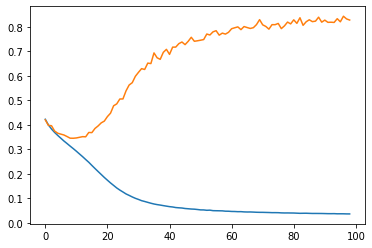

In [18]:
import matplotlib.pyplot as plt
plt.plot(loss_list[1:])
plt.plot(val_loss_list[1:])
plt.savefig('/project/hikaku_db/ziwei/Model_2/Hyper_test/loss_plt_state_1.jpg')

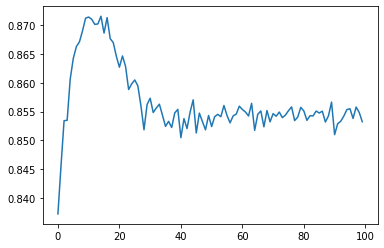

In [19]:
plt.plot(ac_list)
plt.savefig('/project/hikaku_db/ziwei/Model_2/Hyper_test/ac_plt_state_1.jpg')

In [20]:
loss_list = pd.DataFrame([loss_list])
val_loss_list = pd.DataFrame([val_loss_list])
ac_list = pd.DataFrame([ac_list])
loss_list.to_csv('/project/hikaku_db/ziwei/Model_2/Hyper_test/loss_list_state_1.csv',header=False,index=False)
val_loss_list.to_csv('/project/hikaku_db/ziwei/Model_2/Hyper_test/val_loss_list_state_1.csv',header=False,index=False)
ac_list.to_csv('/project/hikaku_db/ziwei/Model_2/Hyper_test/ac_list_state_1.csv',header=False,index=False)

In [32]:
# EPOCH = 2
# loss_list=[]
# los_min=10**10
# val_loss_list=[]
# ac_list=[]

# for epoch in tqdm.tqdm(range(EPOCH)):
#     with torch.no_grad():
#         count=0
#         running_loss=0.0
#         pre=list()
#         lab=list()
#         for _, (inputs, labels) in enumerate(test_dataloader, 0):
#             inputs=inputs.to(DEVICE)
#             labels=labels.to(DEVICE)
#             outputs = Transmodel(inputs)
#             loss =criterion(outputs, labels.squeeze())
#             running_loss += loss.item()
#             count+=1
#             _, predicted = torch.max(F.softmax(outputs).data, 1)
#             predicted=predicted.to('cpu')
#             labels=labels.to('cpu')
#             predicted=predicted.tolist()
#             labels=labels.tolist()
#             pre.append(predicted)
#             lab.append(labels)
#         loss_loss=running_loss/count
#         val_loss_list.append(loss_loss)
#         pre=sum(pre,[])
#         lab=sum(lab,[])
#         print('val_loss:',loss_loss)
#         cl = classification_report(lab, pre,output_dict=True)
#         print(cl)
#         ac_list.append(cl['accuracy'])


  0%|          | 0/2 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


val_loss: 0.2842285505784895



 50%|█████     | 1/2 [02:15<02:15, 135.72s/it]

{'0': {'precision': 0.9643047360451151, 'recall': 0.9388946225844336, 'f1-score': 0.9514300507724053, 'support': 196693}, '1': {'precision': 0.603467178292449, 'recall': 0.33340904788945674, 'f1-score': 0.4295154722134166, 'support': 26415}, '2': {'precision': 0.890987787309704, 'recall': 0.912200161441949, 'f1-score': 0.901469205125722, 'support': 301037}, '3': {'precision': 0.9026397564933343, 'recall': 0.875841274414967, 'f1-score': 0.8890386132046401, 'support': 97174}, '4': {'precision': 0.8108771465877725, 'recall': 0.9061449521628311, 'f1-score': 0.85586811461468, 'support': 108284}, 'accuracy': 0.8927005508475157, 'macro avg': {'precision': 0.834455320945675, 'recall': 0.7932980116987276, 'f1-score': 0.8054642911861727, 'support': 729603}, 'weighted avg': {'precision': 0.8900059403928737, 'recall': 0.8927005508475157, 'f1-score': 0.8894277139773409, 'support': 729603}}
val_loss: 0.2842285505784895



100%|██████████| 2/2 [04:33<00:00, 136.61s/it]

{'0': {'precision': 0.9643047360451151, 'recall': 0.9388946225844336, 'f1-score': 0.9514300507724053, 'support': 196693}, '1': {'precision': 0.603467178292449, 'recall': 0.33340904788945674, 'f1-score': 0.4295154722134166, 'support': 26415}, '2': {'precision': 0.890987787309704, 'recall': 0.912200161441949, 'f1-score': 0.901469205125722, 'support': 301037}, '3': {'precision': 0.9026397564933343, 'recall': 0.875841274414967, 'f1-score': 0.8890386132046401, 'support': 97174}, '4': {'precision': 0.8108771465877725, 'recall': 0.9061449521628311, 'f1-score': 0.85586811461468, 'support': 108284}, 'accuracy': 0.8927005508475157, 'macro avg': {'precision': 0.834455320945675, 'recall': 0.7932980116987276, 'f1-score': 0.8054642911861727, 'support': 729603}, 'weighted avg': {'precision': 0.8900059403928737, 'recall': 0.8927005508475157, 'f1-score': 0.8894277139773409, 'support': 729603}}
